In [ ]:
# Install (versions compatibles + évite le package `keras` standalone)
%pip install -U pip setuptools wheel
%pip install -U tabulate scikit-learn pandas numpy matplotlib seaborn gensim "tensorflow==2.16.1"

https://arxiv.org/abs/2007.12673 - Genetic Algorithm: Reviews, Implementations, and Applications - Tanweer Alam, Shamimul Qamar, Amit Dixit, Mohamed Benaida

# imports

In [2]:
# Suppression des avertissements liés à Scikit-learn
import warnings  # Masquer les avertissements (ex. : FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import gc # garnage collector X) (32Gb suffit pas )

# Librairies générales
import pandas as pd  # Librairie pour la manipulation de données
import numpy as np  # Librairie pour le calcul numérique
import sys  # Fonctions et variables liées à l'interpréteur Python
import copy  # Création de copies d'objets
from numpy import mean, std  # Fonctions de calcul de moyenne et d'écart type
import zipfile  # Traitement de fichiers zip
import os  # Manipulation de fichiers et chemins

# Librairie affichage
import matplotlib.pyplot as plt  # Outils de visualisation 2D
from matplotlib import pyplot  # Interface de la bibliothèque Matplotlib
import seaborn as sns  # Bibliothèque de visualisation de données basée sur Matplotlib

# Scikit-learn pour l'évaluation des modèles
from sklearn.metrics import confusion_matrix  # Matrice de confusion
from sklearn.model_selection import KFold  # Outils de validation croisée
from sklearn.metrics import accuracy_score  # Calcul de l'accuracy
from sklearn.model_selection import train_test_split  # Découpage train/test

# TensorFlow et Keras
import tensorflow as tf  # Librairie de deep learning
import keras  # API haut niveau pour construire et entraîner des modèles de deep learning
from keras import layers  # Modules de couches pour construire des modèles Keras
from keras import models  # Outils pour créer des modèles Keras
from keras import optimizers  # Outils d'optimisation
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Générateur d'images pour l'augmentation des données
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Rappels pour le suivi et l'arrêt précoce
from keras.layers import Input, Dense, Dropout, Flatten, Lambda  # Types de couches Keras
from keras.layers import Conv2D, MaxPooling2D  # Couches convolutionnelles et de pooling
from keras.preprocessing import image  # Outils de prétraitement d'images
from tensorflow.keras.models import Model, load_model  # Définition / chargement de modèles
from keras.datasets import fashion_mnist  # Jeu de données Fashion MNIST
from tensorflow.keras.utils import to_categorical  # Conversion en encodage one-hot
from tensorflow.keras.optimizers import SGD  # Optimiseur Stochastic Gradient Descent
from tensorflow.keras.applications.resnet50 import ResNet50  # Modèle ResNet50 pré-entraîné
from tensorflow.keras.preprocessing import image  # Prétraitement d'images pour les modèles Keras

# DataSet

## File declare

In [3]:
# Définition du répertoire cible
data_dir = "./data/dataset/sheep_cat_elephant_with_caption_600"
data_dir_img = os.path.join(data_dir, "images")
img_height, img_width = 224, 224
batch_size = 32

## Download

In [ ]:
# Création du répertoire s'il n'existe pas
os.makedirs(data_dir, exist_ok=True)

zip_file = "Data_sheep_cat_elephant_with_caption_600.zip"

#!wget https://www.lirmm.fr/~poncelet/Ressources/cnn_models.zip
!Powershell.exe -Command ((new-object System.Net.WebClient).DownloadFile('https://www.lirmm.fr/~poncelet/Ressources/Data_sheep_cat_elephant_with_caption_600.zip','Data_sheep_cat_elephant_with_caption_600.zip'))

# Extraction du fichier ZIP
with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(data_dir)

# Suppression du fichier ZIP après extraction pour économiser de l'espace
os.remove(zip_file)

# GA class

Modèle avec paramètres d'archi modifiables

In [4]:
class ModelInstance:
    def __init__(self, 
                 cLayers, # nombre de couches convolutionnelles
                 cDims, # [(nb_filtres : int, taille_filtres : (int, int), taille_pooling : (int, int))]
                 dLayers, # nombre de couches denses
                 dDims, # [nb_neurones : int]
                 dropout, # taux de dropout (ignoré si 0f)
                 input_shape, # (int, int, int)
                 output_shape, # int
                 name
                 ):
        # couche d'entrée
        input = Input(shape=input_shape, name="input")
        x = input
        # couches conv
        for i in range(cLayers):
            x = Conv2D(cDims[i][0], cDims[i][1], activation="relu", name=f"conv_{i+1}")(x)
            x = MaxPooling2D(cDims[i][2], name=f"pool_{i+1}")(x)
        # flatten
        x = Flatten(name="flatten")(x)
        # couches denses
        for i in range(dLayers):
            x = Dense(dDims[i], activation="relu", name=f"dense_{i+1}")(x)
        # couche de sortie
        if dropout[0] > 0:
            x = Dropout(dropout[0], name="dropout")(x)
        output = Dense(output_shape, activation="softmax", name="output")(x)
        model = Model(inputs=input, outputs=output, name=name)
        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
        self.model = model
        self.cLayers = cLayers
        self.cDims = cDims
        self.dLayers = dLayers
        self.dDims = dDims
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.name = name
    def summary(self):
        return self.model.summary()
    def fit(self, x, y=None, **kwargs):
        return self.model.fit(x, y, **kwargs)
    def evaluate(self, x, y=None, **kwargs):
        return self.model.evaluate(x, y, **kwargs)

    def predict(self, x, **kwargs):
        return self.model.predict(x, **kwargs)

    def save(self, path):
        self.model.save(path)

    def load(self, path):
        self.model = load_model(path)

Gene + Modèle

In [5]:
class Entity:
    def __init__(self,
                 cDims, # [(nb_filtres : int, taille_filtres : (int, int), taille_pooling : (int, int))]
                 dDims, # [nb_neurones : int]
                 dropout, # taux de dropout (ignoré si 0f)
                 input_shape, # (int, int, int)
                 output_shape, # int,
                 name
                 ):
        self.cLayers = len(cDims)
        self.cDims = cDims
        self.dLayers = len(dDims)
        self.dDims = dDims
        self.dropout = dropout
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.model_instance = ModelInstance(self.cLayers, cDims, self.dLayers, dDims, dropout, input_shape, output_shape, name)
        self.name = name
        self.loss = None
        self.accuracy = None
        self.complexity = self.compute_complexity()
    def evaluate_fitness(self, test_data):
        self.loss, self.accuracy = self.model_instance.evaluate(test_data)
        return self.accuracy
    def compute_complexity(self):
        c = 0.0
        # juste trainable params sans l'optimizers
        c += self.model_instance.model.count_params()
        return c
    def summary(self):
        return self.model_instance.summary()
    def fit(self, x, y=None, **kwargs):
        return self.model_instance.fit(x, y, **kwargs)

    def evaluate(self, x, y=None, **kwargs):
        self.loss, self.accuracy = self.model_instance.evaluate(x, y, **kwargs)
        return self.loss, self.accuracy

    def predict(self, x, **kwargs):
        return self.model_instance.predict(x, **kwargs)

    def reset(self):
        self.model_instance = ModelInstance(
            self.cLayers, self.cDims, self.dLayers, self.dDims, self.dropout, self.input_shape, self.output_shape, self.name
        )
        self.loss = None
        self.accuracy = None
        return self

## Data + train

In [6]:
def load_dataset():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir_img,
        validation_split=0.3,
        subset="training",
        seed=124,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir_img,
        validation_split=0.3,
        subset="validation",
        seed=124,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    X_train_list, y_train_list = [], []
    for x, y in train_ds:
        X_train_list.append(x.numpy())
        y_train_list.append(y.numpy())

    X_test_list, y_test_list = [], []
    for x, y in val_ds:
        X_test_list.append(x.numpy())
        y_test_list.append(y.numpy())

    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)
    X_test = np.concatenate(X_test_list, axis=0)
    y_test = np.concatenate(y_test_list, axis=0)

    # One-hot
    numClass = len(train_ds.class_names)
    y_train = to_categorical(y_train, num_classes=numClass)
    y_test = to_categorical(y_test, num_classes=numClass)

    return X_train, y_train, X_test, y_test

In [7]:
def clean_data(train, test):
    """
    Prétraitement des données : conversion en float, normalisation entre 0 et 1.

    Paramètres :
    - train : tableau de données d'entraînement
    - test : tableau de données de test

    Retourne :
    - train_norm : données d'entraînement normalisées
    - test_norm : données de test normalisées
    """
    # Conversion des entiers en floats pour permettre la normalisation
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')

    # Normalisation des valeurs entre 0 et 1
    train_norm /= 255.0
    test_norm /= 255.0

    return train_norm, test_norm

In [8]:
def evaluate_model(model, dataX, dataY, folds=5, epochs=10):
    """
    Évalue le modèle avec une validation croisée K-fold.

    Paramètres :
    - model : modèle de réseau de neurones Keras à évaluer.
    - dataX : données d'entrée pour l'entraînement et la validation.
    - dataY : étiquettes de sortie correspondantes.
    - folds : nombre de splits pour la validation croisée.
    - epochs : nombre d'époques pour l'entraînement de chaque split.

    Retourne :
    - scores : liste des scores d'accuracy du modèle pour chaque split.
    - histories : liste des historique d'entraînement pour chaque split.
    """
    scores, losses, histories = [], [], []  # Initialisation des scores, pertes et historiques
    kfold = KFold(n_splits=folds, shuffle=True, random_state=1)
    callbacks = [EarlyStopping(monitor='val_loss', patience=5,
                      restore_best_weights=True, verbose=1)]
    # Itération sur chaque split généré par le K-fold
    for train_ix, test_ix in kfold.split(dataX):
        # Sélection des données d'entraînement et de test pour le fold
        X_train, y_train = dataX[train_ix], dataY[train_ix]
        X_test, y_test = dataX[test_ix], dataY[test_ix]

        # Réinitialisation du modèle avant chaque itération
        model = model.reset()


        # Entraînement du modèle
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=32,
            verbose=1,
            callbacks=callbacks
        )

        # Évaluation du modèle sur les données de test actuelles
        loss, acc = model.evaluate(X_test, y_test, verbose=True)

        # Stockage de l'historique
        scores.append(acc)
        losses.append(loss)
        histories.append(history)

    # Accuracies moyennées pour la sélection GA
    model.accuracy = float(np.mean(scores))
    model.loss = float(np.mean(losses))

    return scores, histories

In [9]:
def plot_curves(histories):
    """
    Fonction pour afficher les courbes de loss et d'accuracy
    moyennees et ecart-types a travers les k-folds.

    Parametres :
    - histories (list) : Historique d'entrainement des differents plis K-folds.
    """

    # Aligne les historiques sur la longueur minimale (early stopping).
    min_len = min(len(h.history["loss"]) for h in histories)
    trimmed = []
    for h in histories:
        trimmed.append({k: v[:min_len] for k, v in h.history.items()})

    # Initialisation des figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Extraction du nombre d'epoques d'apres l'un des historiques
    epochs = range(min_len)

    # Calcul des moyennes et des ecart-types pour chaque epoque
    mean_loss = np.mean([h["loss"] for h in trimmed], axis=0)
    std_loss = np.std([h["loss"] for h in trimmed], axis=0)

    mean_val_loss = np.mean([h["val_loss"] for h in trimmed], axis=0)
    std_val_loss = np.std([h["val_loss"] for h in trimmed], axis=0)

    mean_accuracy = np.mean([h["accuracy"] for h in trimmed], axis=0)
    std_accuracy = np.std([h["accuracy"] for h in trimmed], axis=0)

    mean_val_accuracy = np.mean([h["val_accuracy"] for h in trimmed], axis=0)
    std_val_accuracy = np.std([h["val_accuracy"] for h in trimmed], axis=0)

    # Couleurs pour les courbes
    train_color = 'blue'
    val_color = 'orange'

    # Courbes de loss avec moyenne et ecart-type
    ax1.plot(epochs, mean_loss, color=train_color, label='Train')
    ax1.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss,
                     color=train_color, alpha=0.2)

    ax1.plot(epochs, mean_val_loss, color=val_color, label='Validation')
    ax1.fill_between(epochs, mean_val_loss - std_val_loss,
                     mean_val_loss + std_val_loss, color=val_color, alpha=0.2)

    # Courbes d'accuracy avec moyenne et ecart-type
    ax2.plot(epochs, mean_accuracy, color=train_color, label='Train')
    ax2.fill_between(epochs, mean_accuracy - std_accuracy,
                     mean_accuracy + std_accuracy, color=train_color, alpha=0.2)

    ax2.plot(epochs, mean_val_accuracy, color=val_color, label='Validation')
    ax2.fill_between(epochs, mean_val_accuracy - std_val_accuracy,
                     mean_val_accuracy + std_val_accuracy,
                     color=val_color, alpha=0.2)

    # Titres, labels et legendes
    ax1.set_title(f'Loss (k={len(histories)})')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title(f'Accuracy (k={len(histories)})')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

In [10]:
def run_evaluation(folds, epochs, model, X_train, y_train, X_test, y_test):
    """
    Fonction d'évaluation

    Cette fonction effectue les étapes suivantes :
    1. Chargement du jeu de données Fashion MNIST.
    2. Prétraitement des données : nettoyage et normalisation.
    3. Initialisation du modèle de base et affichage de sa structure.
    4. Évaluation du modèle avec validation croisée (K-fold).
    5. Affichage des courbes de performance et des statistiques de précision.

    Paramètres :
    - folds (int) : Nombre de splits pour la validation croisée (K-fold).
    - epochs (int) : Nombre d'époques d'entraînement pour chaque pli du K-fold.
    - model : Modèle à évaluer
    Retourne :
    - None
    """

    # Chargement du jeu de données d'entraînement et de test
    #X_train, y_train, X_test, y_test = load_dataset()

    # Prétraitement des données : nettoyage et normalisation
    #X_train, X_test = clean_data(X_train, X_test)

    # Initialisation du modèle de base
    
    print(model.summary())

    # Évaluation du modèle
    scores, histories = evaluate_model(model, X_train, y_train, folds, epochs)

    # Affichage des courbes de performance
    plot_curves(histories)

    # Affichage des statistiques de précision : moyenne et écart-type
    print(f'Précision : moyenne={mean(scores) * 100:.3f}% écart-type={std(scores) * 100:.3f}%, k={len(scores)}')

# GA RUN

## params

In [11]:
# Base Gene
conv = 4
cDims = [
    (6, (3, 3), (2, 2)),
    (32, (5, 5), (2, 2))
    ]
dense = 1
dDims = [100]
dropout = [0.0]
input_shape = (img_height, img_width, 3)
output_shape = 3
epochs = 20
folds = 3
# choices :
# 1. Add conv layer
# 2. pop conv layer
# 3. change a conv layer param
#   3.1 change nb_filtres
#   3.2 change taille_filtres
#   3.3 change taille_pooling
# 4. add dense layer
# 5. pop dense layer
# 6. change a dense layer param
#  6.1 change nb_neurones

# Pop params
num_pop = 20
num_gen = 5

In [16]:
def mutate(conv, cDims, dense, dDims, dropout):
    taille_filtres = [(3, 3), (5, 5), (7, 7)]
    nb_filtres = [6, 8, 16, 32, 64, 128]
    taille_pooling = [(2, 2), (3, 3)]
    neur_dense = [10, 20, 50, 100]
    dropout_values = [0.0, 0.5, 0.75]
    d = dense
    c = conv
    mutation_type = np.random.randint(1, 8)
    if mutation_type == 1: # add conv layer
        if c < 6:
            c += 1
            cDims.append((nb_filtres[0], taille_filtres[0], taille_pooling[0]))
        else:
            return mutate(c, cDims, d, dDims, dropout)
    elif mutation_type == 2: # pop conv layer
        if c > 2:
            c -= 1
            cDims.pop()
        else:
            return mutate(c, cDims, d, dDims, dropout)
    elif mutation_type == 3: # change a conv layer param
        layer_idx = np.random.randint(0, c)
        param_idx = np.random.randint(0, 3)
        if param_idx == 0: # change nb_filtres
            cDims[layer_idx] = (np.random.choice(nb_filtres), cDims[layer_idx][1], cDims[layer_idx][2])
        elif param_idx == 1: # change taille_filtres
            cDims[layer_idx] = (cDims[layer_idx][0], taille_filtres[np.random.randint(0, len(taille_filtres))], cDims[layer_idx][2])
        else: # change taille_pooling
            cDims[layer_idx] = (cDims[layer_idx][0], cDims[layer_idx][1], taille_pooling[np.random.randint(0, len(taille_pooling))])
    elif mutation_type == 4: # add dense layer
        if d < 2:
            d += 1
            dDims.append(neur_dense[0])
        else:
            return mutate(c, cDims, d, dDims, dropout)
    elif mutation_type == 5: # pop dense
        if d > 1:
            d -= 1
            dDims.pop()
    elif mutation_type == 6: # change dropout
        dropout = [np.random.choice(dropout_values)]
    else: # change a dense param
        if d > 0:
            layer_idx = np.random.randint(0, d)
            dDims[layer_idx] = np.random.choice(neur_dense)
        else:
            return mutate(c, cDims, d, dDims, dropout)
    return c, cDims, d, dDims, dropout


def mutate_unique(cDims, dDims, existing_configs, dropout):
    for _ in range(10):  # Limite le nombre de tentatives pour trouver une mutation unique
        new_config = mutate(len(cDims), cDims, len(dDims), dDims, dropout)
        valid = True
        for config in existing_configs:
            conv_match = False
            cDims_match = True
            if new_config[0] == config[0]: # conv
                conv_match = True
                for i in range(len(new_config[1])):
                    if new_config[1][i] != config[1][i]: # cDims
                        cDims_match = False
            dense_match = False
            dDims_match = True
            if new_config[2] == config[2]: # dense
                dense_match = True
                for i in range(len(new_config[3])):
                    if new_config[3][i] != config[3][i]: # dDims
                        dDims_match = False
            dropout_match = False
            if new_config[4] == config[4]: # dropout
                 dropout_match = True
            if conv_match and cDims_match and dense_match and dDims_match and dropout_match:
                valid = False
                break
        if valid:
            existing_configs.append(new_config)
            return new_config[1], new_config[3], new_config[4]
        else:
            return mutate_unique(cDims, dDims, existing_configs, dropout)

## Run

Found 1800 files belonging to 3 classes.
Using 1260 files for training.
Found 1800 files belonging to 3 classes.
Using 540 files for validation.
Generation 1


Model: "0_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 32)   │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 89888)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     8,988,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,994,203 (34.31 MB)

 Trainable params: 8,994,203 (34.31 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.3929 - loss: 1.7674 - val_accuracy: 0.4881 - val_loss: 0.9814
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5571 - loss: 0.9131 - val_accuracy: 0.5762 - val_loss: 0.9149
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6905 - loss: 0.7428 - val_accuracy: 0.6119 - val_loss: 0.8503
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8238 - loss: 0.4701 - val_accuracy: 0.6643 - val_loss: 0.7788
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9155 - loss: 0.2744 - val_accuracy: 0.6643 - val_loss: 0.8203
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9643 - loss: 0.1351 - val_accuracy: 0.7095 - val_loss: 0.8689
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9893 - loss: 0.0644 - val_accuracy: 0.6643 - val_loss: 1.0529
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9976 - loss: 0.0276 - val_accuracy: 0.664

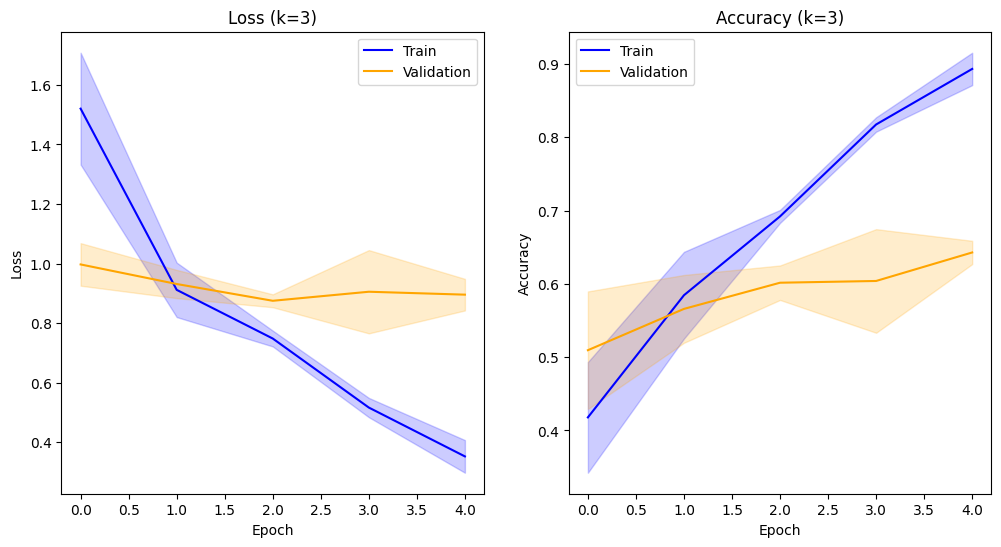

Précision : moyenne=56.825% écart-type=10.397%, k=3


Model: "0_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 32)   │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 51, 51, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 25, 25, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3750)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │       375,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 382,137 (1.46 MB)

 Trainable params: 382,137 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4905 - loss: 1.0130 - val_accuracy: 0.6524 - val_loss: 0.8292
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5833 - loss: 0.9358 - val_accuracy: 0.5857 - val_loss: 0.9003
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6298 - loss: 0.8709 - val_accuracy: 0.6333 - val_loss: 0.7995
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6560 - loss: 0.8167 - val_accuracy: 0.6524 - val_loss: 0.7796
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6917 - loss: 0.7564 - val_accuracy: 0.6405 - val_loss: 0.7500
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7202 - loss: 0.6890 - val_accuracy: 0.6714 - val_loss: 0.7472
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7548 - loss: 0.6002 - val_accuracy: 0.7119 - val_loss: 0.7073
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8012 - loss: 0.4872 - val_accuracy: 0.681

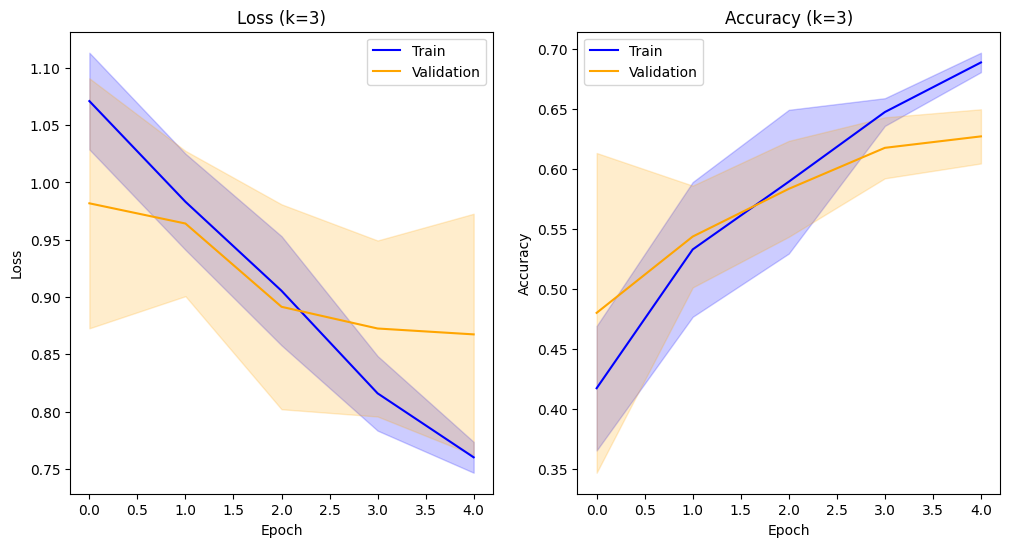

Précision : moyenne=50.000% écart-type=15.909%, k=3


Model: "0_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 105, 105, 32)   │         9,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     8,652,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,662,811 (33.05 MB)

 Trainable params: 8,662,811 (33.05 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3393 - loss: 1.9873 - val_accuracy: 0.3143 - val_loss: 1.0660
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4310 - loss: 1.0264 - val_accuracy: 0.4524 - val_loss: 1.0509
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5857 - loss: 0.8966 - val_accuracy: 0.5048 - val_loss: 1.0537
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7381 - loss: 0.6587 - val_accuracy: 0.5333 - val_loss: 1.1010
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8905 - loss: 0.3605 - val_accuracy: 0.5190 - val_loss: 1.2969
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9524 - loss: 0.1958 - val_accuracy: 0.5262 - val_loss: 1.3922
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9714 - loss: 0.1319 - val_accuracy: 0.5452 - val_loss: 1.5272
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
14/14 ━━━━━━━━━━━━━━━━━

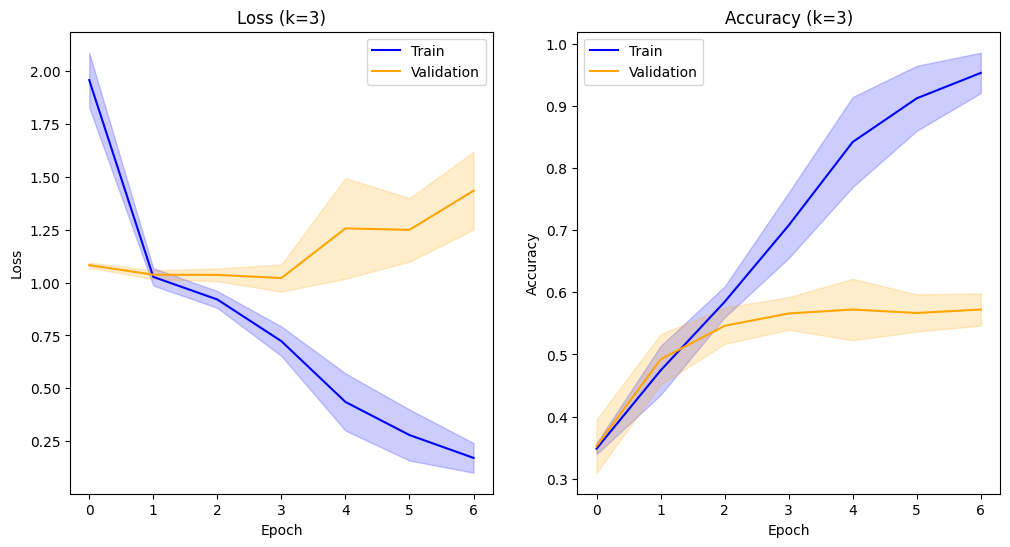

Précision : moyenne=53.810% écart-type=6.212%, k=3


Model: "0_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 32)   │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 51, 51, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 25, 25, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 23, 23, 6)      │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_4 (MaxPooling2D)           │ (None, 11, 11, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 726)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        72,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,067 (312.76 KB)

 Trainable params: 80,067 (312.76 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4095 - loss: 1.0773 - val_accuracy: 0.6000 - val_loss: 0.9726
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5821 - loss: 0.9012 - val_accuracy: 0.6024 - val_loss: 0.8662
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6274 - loss: 0.8282 - val_accuracy: 0.6833 - val_loss: 0.7424
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6869 - loss: 0.7808 - val_accuracy: 0.6905 - val_loss: 0.7584
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6810 - loss: 0.7507 - val_accuracy: 0.7000 - val_loss: 0.7023
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6976 - loss: 0.7285 - val_accuracy: 0.6905 - val_loss: 0.7528
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7060 - loss: 0.6921 - val_accuracy: 0.7048 - val_loss: 0.6941
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7512 - loss: 0.6399 - val_accuracy: 0.640

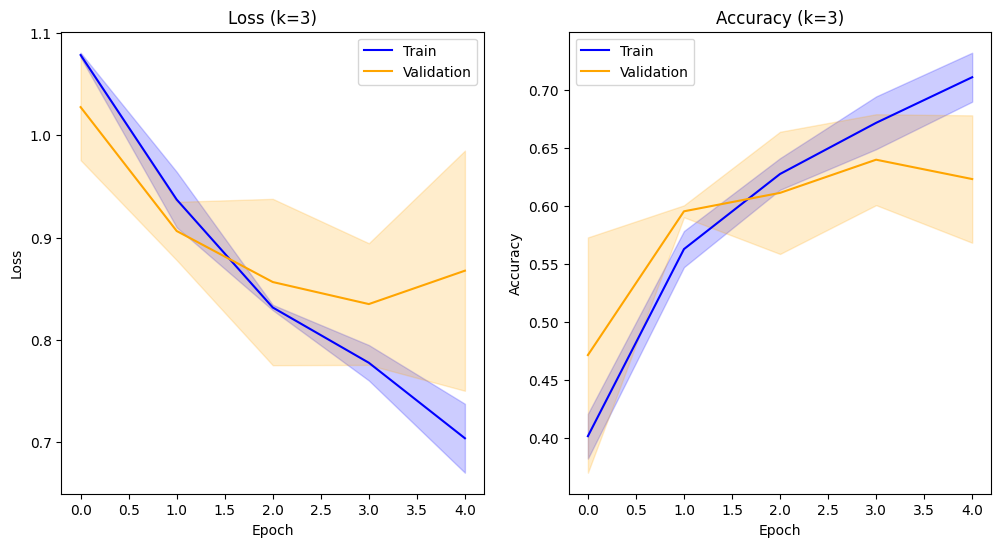

Précision : moyenne=50.714% écart-type=14.832%, k=3


Model: "0_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 32)   │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 89888)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     8,988,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,994,943 (34.31 MB)

 Trainable params: 8,994,943 (34.31 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.4131 - loss: 1.3357 - val_accuracy: 0.5190 - val_loss: 1.0444
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5262 - loss: 0.9995 - val_accuracy: 0.5238 - val_loss: 1.0424
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6857 - loss: 0.8216 - val_accuracy: 0.5857 - val_loss: 1.0084
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8714 - loss: 0.4336 - val_accuracy: 0.6000 - val_loss: 0.9449
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9476 - loss: 0.1975 - val_accuracy: 0.6548 - val_loss: 1.1939
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9762 - loss: 0.0927 - val_accuracy: 0.5690 - val_loss: 1.9321
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9929 - loss: 0.0402 - val_accuracy: 0.5833 - val_loss: 1.5257
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9952 - loss: 0.0253 - val_accuracy: 0.623

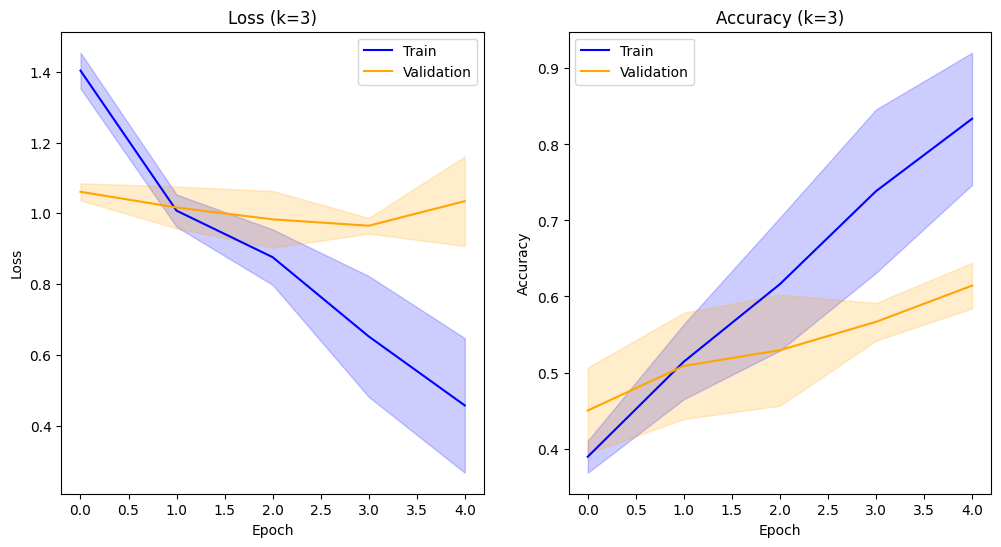

Précision : moyenne=51.905% écart-type=9.813%, k=3


Model: "0_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 32)   │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 89888)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │     4,494,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,499,603 (17.16 MB)

 Trainable params: 4,499,603 (17.16 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.3702 - loss: 1.4100 - val_accuracy: 0.4143 - val_loss: 1.0553
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4929 - loss: 0.9944 - val_accuracy: 0.5810 - val_loss: 0.9806
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6940 - loss: 0.8123 - val_accuracy: 0.5714 - val_loss: 0.9715
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7845 - loss: 0.6150 - val_accuracy: 0.7024 - val_loss: 0.7779
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8726 - loss: 0.4068 - val_accuracy: 0.6905 - val_loss: 0.8064
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9393 - loss: 0.2433 - val_accuracy: 0.6119 - val_loss: 1.0124
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9548 - loss: 0.1561 - val_accuracy: 0.6690 - val_loss: 0.9857
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9857 - loss: 0.0796 - val_accuracy: 0.673

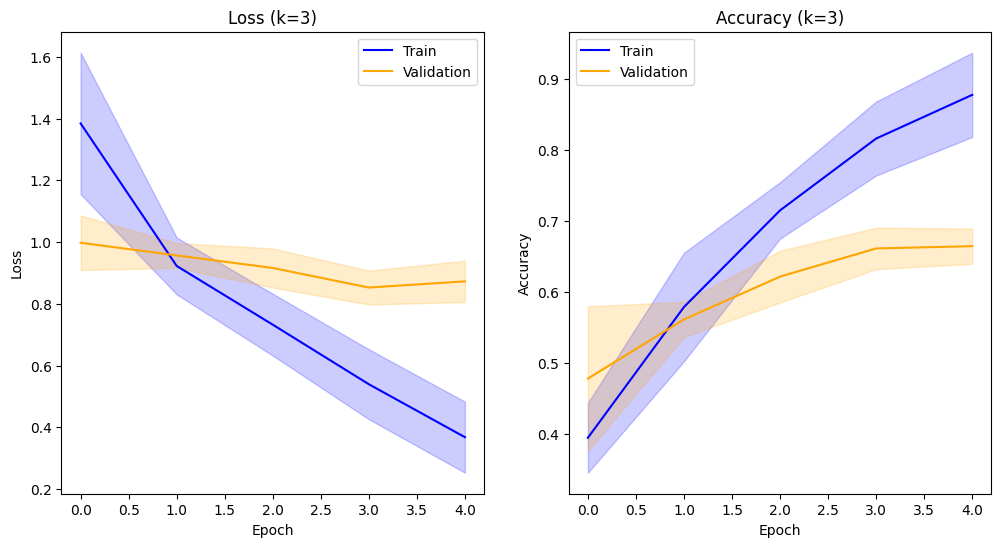

Précision : moyenne=57.381% écart-type=12.889%, k=3


Model: "0_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 32)   │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 51, 51, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 25, 25, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3750)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │       375,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 382,877 (1.46 MB)

 Trainable params: 382,877 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3833 - loss: 1.0920 - val_accuracy: 0.5024 - val_loss: 1.0523
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4679 - loss: 1.0218 - val_accuracy: 0.4429 - val_loss: 1.0032
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5417 - loss: 0.9560 - val_accuracy: 0.6405 - val_loss: 0.8263
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6226 - loss: 0.8305 - val_accuracy: 0.7071 - val_loss: 0.7501
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6857 - loss: 0.7505 - val_accuracy: 0.6905 - val_loss: 0.8090
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7190 - loss: 0.7038 - val_accuracy: 0.7071 - val_loss: 0.7145
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7190 - loss: 0.6848 - val_accuracy: 0.6643 - val_loss: 0.7507
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7202 - loss: 0.6500 - val_accuracy: 0.695

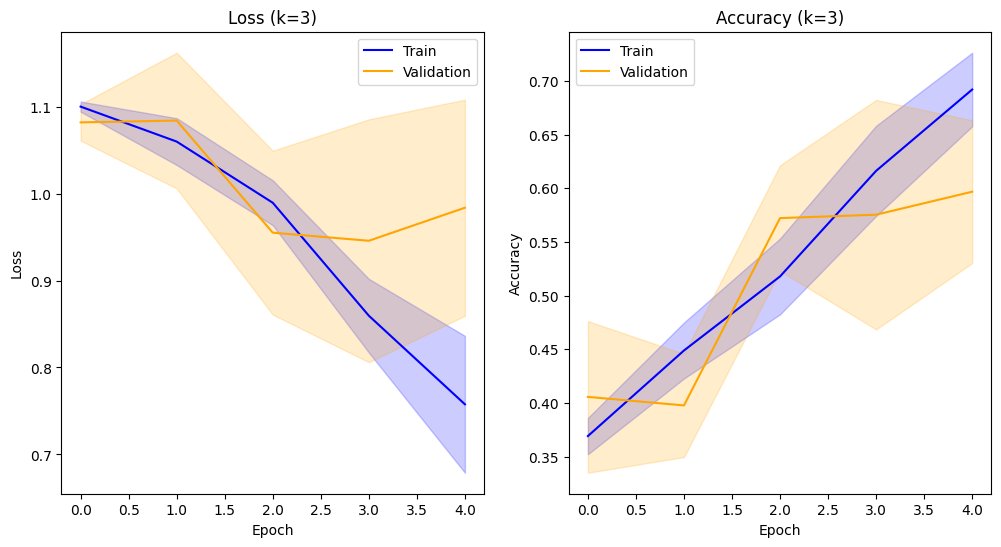

Précision : moyenne=47.937% écart-type=17.373%, k=3


Model: "0_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 32)   │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 89888)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     8,988,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,994,203 (34.31 MB)

 Trainable params: 8,994,203 (34.31 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.3381 - loss: 2.2470 - val_accuracy: 0.4048 - val_loss: 1.0961
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4107 - loss: 1.0720 - val_accuracy: 0.5524 - val_loss: 1.0001
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5155 - loss: 1.0055 - val_accuracy: 0.5190 - val_loss: 1.0483
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4750 - loss: 0.9962 - val_accuracy: 0.5381 - val_loss: 1.0205
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5798 - loss: 0.9552 - val_accuracy: 0.5952 - val_loss: 0.9938
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6345 - loss: 0.8766 - val_accuracy: 0.6000 - val_loss: 0.9914
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6476 - loss: 0.8002 - val_accuracy: 0.5595 - val_loss: 0.9660
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7369 - loss: 0.6852 - val_accuracy: 0.573

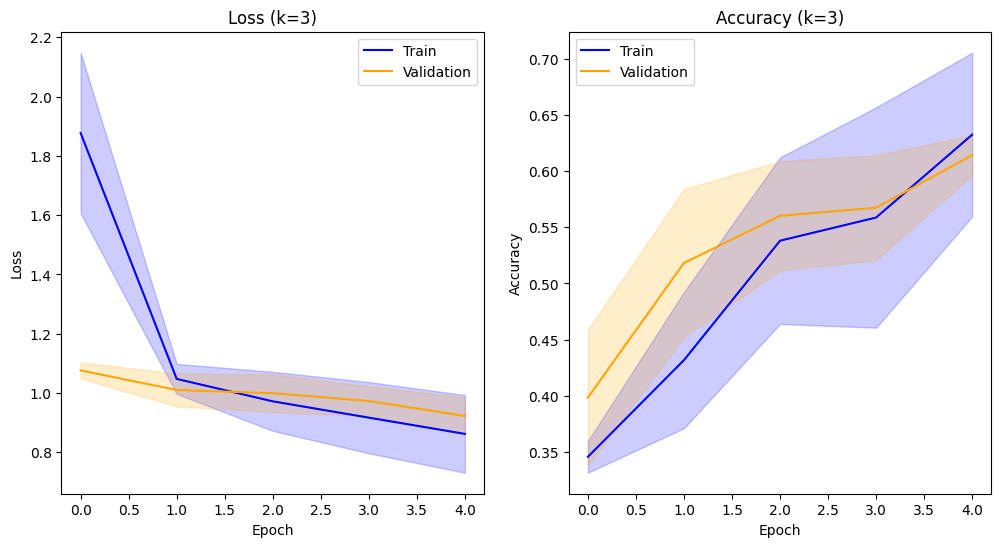

Précision : moyenne=56.746% écart-type=8.378%, k=3


Model: "0_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 32)   │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 89888)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     8,988,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,042,227 (34.49 MB)

 Trainable params: 9,042,227 (34.49 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.3440 - loss: 1.3669 - val_accuracy: 0.5286 - val_loss: 1.0428
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.5274 - loss: 1.0523 - val_accuracy: 0.5429 - val_loss: 1.0151
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.5881 - loss: 0.9680 - val_accuracy: 0.5476 - val_loss: 1.0051
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.6190 - loss: 0.9192 - val_accuracy: 0.5286 - val_loss: 1.0292
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.6940 - loss: 0.7357 - val_accuracy: 0.4214 - val_loss: 1.3896
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.7821 - loss: 0.5345 - val_accuracy: 0.5167 - val_loss: 1.2014
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.8857 - loss: 0.3321 - val_accuracy: 0.5214 - val_loss: 1.5097
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.9536 - loss: 0.1751 - val_accurac

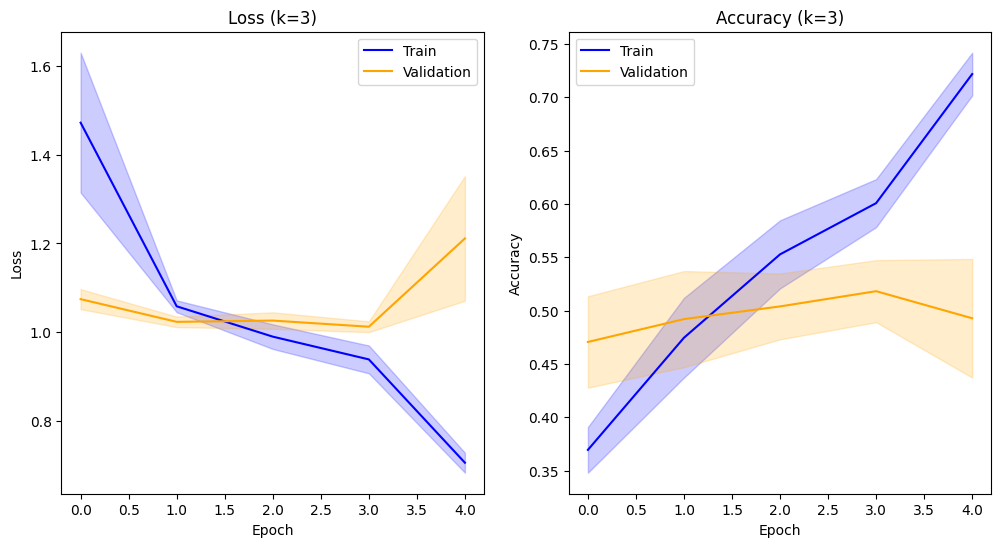

Précision : moyenne=51.746% écart-type=4.265%, k=3


Model: "0_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     9,331,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,333,531 (35.60 MB)

 Trainable params: 9,333,531 (35.60 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3952 - loss: 1.2271 - val_accuracy: 0.5286 - val_loss: 1.0148
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6024 - loss: 0.9314 - val_accuracy: 0.6381 - val_loss: 0.8315
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7440 - loss: 0.6753 - val_accuracy: 0.6452 - val_loss: 0.8312
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8464 - loss: 0.4394 - val_accuracy: 0.6167 - val_loss: 0.8829
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9476 - loss: 0.2351 - val_accuracy: 0.6310 - val_loss: 0.8617
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9786 - loss: 0.1056 - val_accuracy: 0.5714 - val_loss: 1.5465
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9905 - loss: 0.0540 - val_accuracy: 0.6405 - val_loss: 1.0971
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 0.661

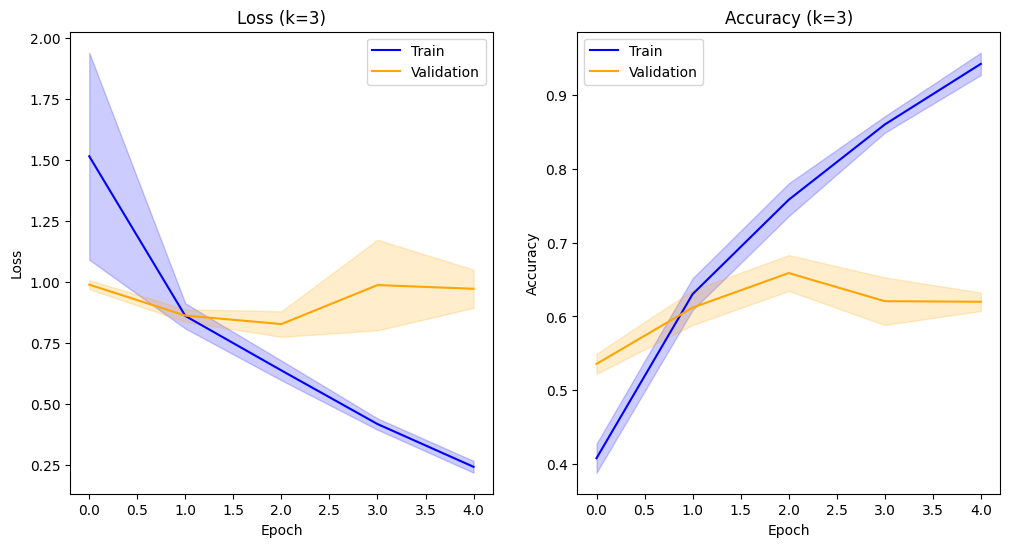

Précision : moyenne=63.095% écart-type=5.727%, k=3


Model: "0_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 32)   │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 89888)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │     1,797,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,802,843 (6.88 MB)

 Trainable params: 1,802,843 (6.88 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3595 - loss: 2.0074 - val_accuracy: 0.4571 - val_loss: 1.0825
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4131 - loss: 1.0563 - val_accuracy: 0.4262 - val_loss: 1.0394
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4583 - loss: 1.0159 - val_accuracy: 0.5119 - val_loss: 1.0213
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4940 - loss: 0.9753 - val_accuracy: 0.4500 - val_loss: 0.9960
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5131 - loss: 0.9220 - val_accuracy: 0.5000 - val_loss: 0.9763
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5286 - loss: 0.8835 - val_accuracy: 0.4786 - val_loss: 0.9633
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6119 - loss: 0.8369 - val_accuracy: 0.5190 - val_loss: 0.9898
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6440 - loss: 0.7969 - val_accuracy: 0.554

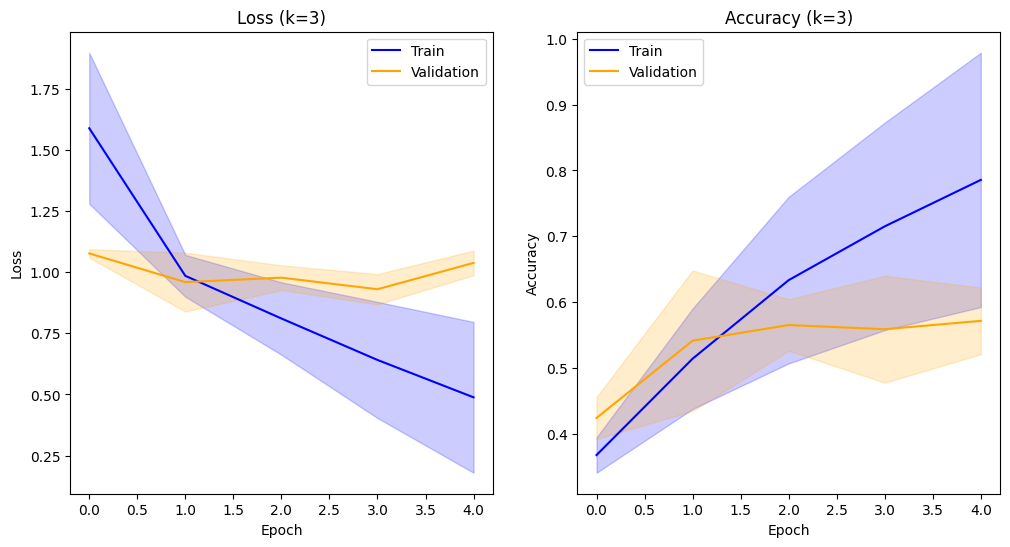

Précision : moyenne=53.175% écart-type=10.877%, k=3


Model: "0_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 74, 74, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 70, 70, 32)     │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 39200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     3,920,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,925,403 (14.97 MB)

 Trainable params: 3,925,403 (14.97 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3631 - loss: 1.6623 - val_accuracy: 0.3119 - val_loss: 1.0889
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3643 - loss: 1.0526 - val_accuracy: 0.5000 - val_loss: 1.0438
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5762 - loss: 0.9396 - val_accuracy: 0.5762 - val_loss: 0.9381
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7083 - loss: 0.7103 - val_accuracy: 0.6286 - val_loss: 0.8506
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7929 - loss: 0.5351 - val_accuracy: 0.6738 - val_loss: 0.7750
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8917 - loss: 0.3427 - val_accuracy: 0.6381 - val_loss: 0.8764
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9476 - loss: 0.2150 - val_accuracy: 0.6476 - val_loss: 0.9616
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9714 - loss: 0.1313 - val_accuracy: 0.645

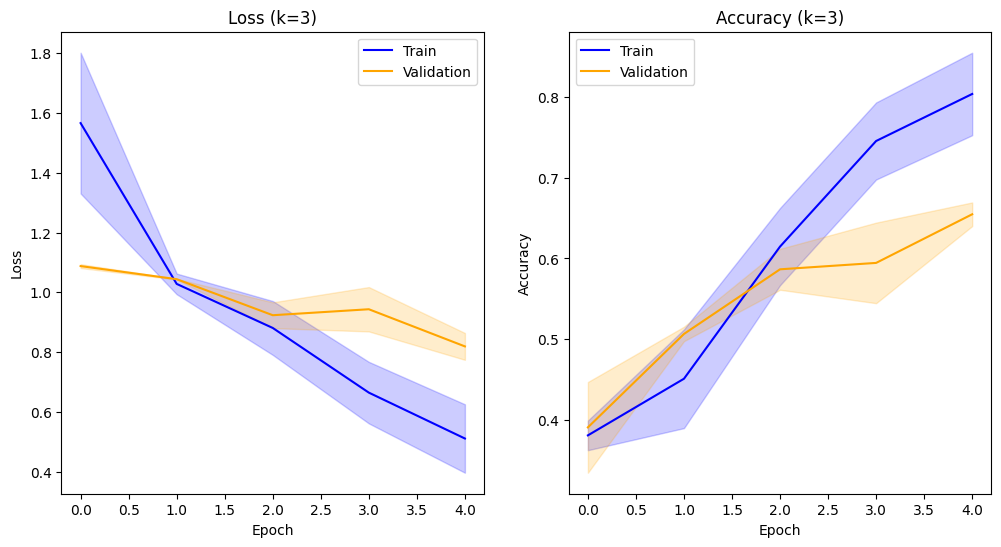

Précision : moyenne=51.111% écart-type=11.538%, k=3


Model: "0_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 32)   │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 51, 51, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 25, 25, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3750)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │        75,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,817 (319.60 KB)

 Trainable params: 81,817 (319.60 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3929 - loss: 1.0954 - val_accuracy: 0.4071 - val_loss: 1.0520
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5036 - loss: 0.9615 - val_accuracy: 0.6262 - val_loss: 0.8243
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6131 - loss: 0.8592 - val_accuracy: 0.6238 - val_loss: 0.8281
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6655 - loss: 0.8029 - val_accuracy: 0.6119 - val_loss: 0.9276
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6369 - loss: 0.8280 - val_accuracy: 0.6548 - val_loss: 0.7837
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6774 - loss: 0.7465 - val_accuracy: 0.6381 - val_loss: 0.7654
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7345 - loss: 0.6685 - val_accuracy: 0.6595 - val_loss: 0.7666
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7381 - loss: 0.6395 - val_accuracy: 0.697

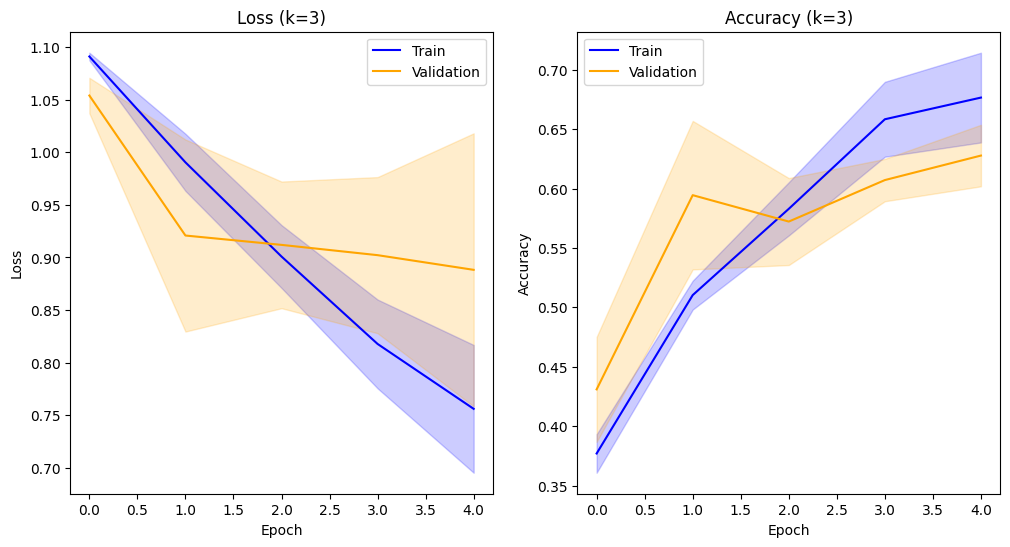

Précision : moyenne=52.778% écart-type=12.685%, k=3


Model: "0_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │       933,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 935,091 (3.57 MB)

 Trainable params: 935,091 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3940 - loss: 1.0709 - val_accuracy: 0.4619 - val_loss: 0.9417
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4690 - loss: 0.9230 - val_accuracy: 0.5333 - val_loss: 0.8881
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6821 - loss: 0.7576 - val_accuracy: 0.6786 - val_loss: 0.7270
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7988 - loss: 0.5852 - val_accuracy: 0.6643 - val_loss: 0.7235
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8940 - loss: 0.3984 - val_accuracy: 0.7143 - val_loss: 0.7044
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9417 - loss: 0.2515 - val_accuracy: 0.7095 - val_loss: 0.7303
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9738 - loss: 0.1437 - val_accuracy: 0.7143 - val_loss: 0.8096
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9869 - loss: 0.0830 - val_accuracy: 0.652

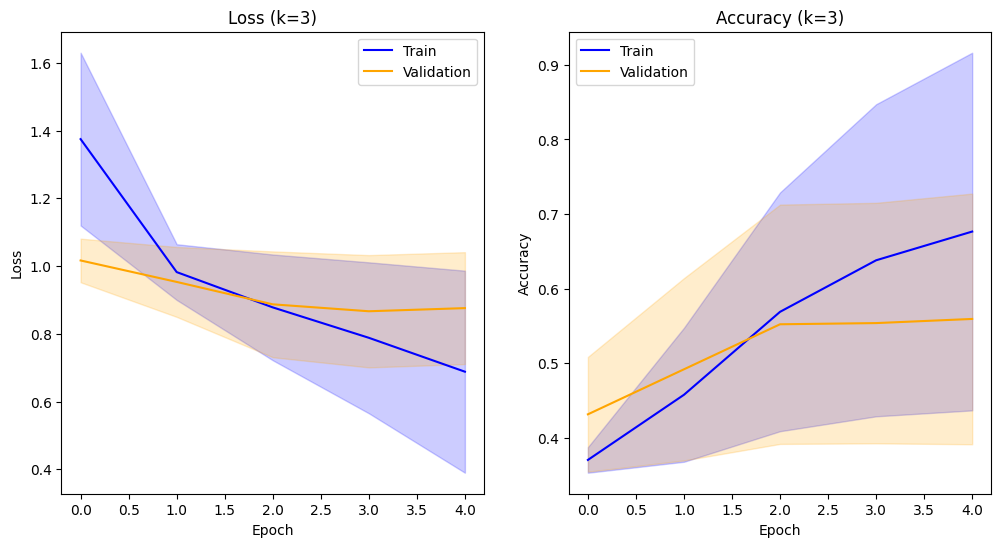

Précision : moyenne=51.587% écart-type=15.856%, k=3


Model: "0_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 64)   │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 179776)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │     8,988,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,998,835 (34.33 MB)

 Trainable params: 8,998,835 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.3369 - loss: 1.5353 - val_accuracy: 0.4048 - val_loss: 1.0827
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5714 - loss: 0.9934 - val_accuracy: 0.6333 - val_loss: 0.8669
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6417 - loss: 0.8280 - val_accuracy: 0.6262 - val_loss: 0.8784
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7131 - loss: 0.6948 - val_accuracy: 0.6881 - val_loss: 0.7783
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.8250 - loss: 0.5075 - val_accuracy: 0.6381 - val_loss: 0.8309
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.8917 - loss: 0.3664 - val_accuracy: 0.6881 - val_loss: 0.8053
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9369 - loss: 0.2388 - val_accuracy: 0.6929 - val_loss: 0.9366
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9631 - loss: 0.1592 - val_accuracy: 0.685

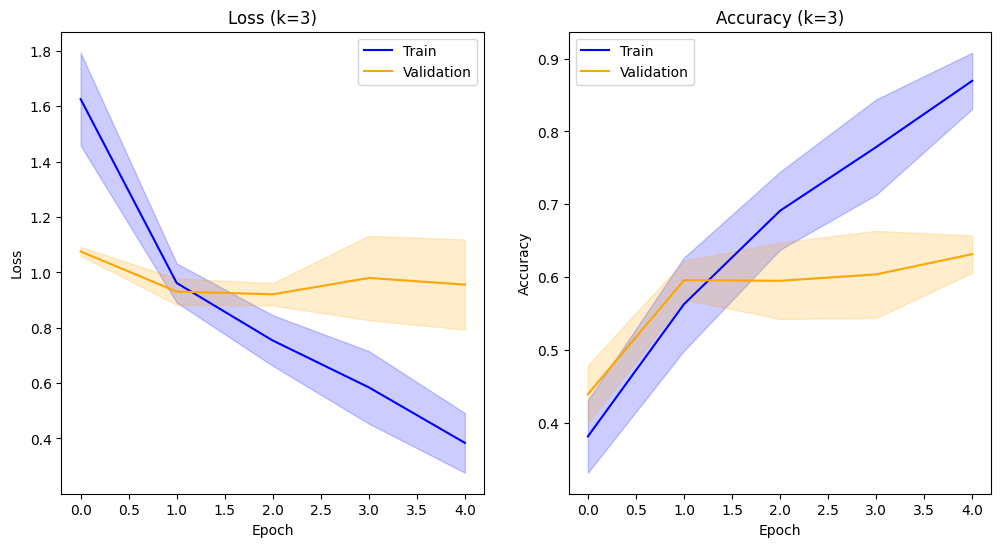

Précision : moyenne=53.413% écart-type=11.323%, k=3


Model: "0_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 32)   │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 51, 51, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 25, 25, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3750)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │       187,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,437 (759.52 KB)

 Trainable params: 194,437 (759.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3310 - loss: 1.0989 - val_accuracy: 0.3429 - val_loss: 1.0870
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3833 - loss: 1.0531 - val_accuracy: 0.4738 - val_loss: 1.0611
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5310 - loss: 1.0103 - val_accuracy: 0.5167 - val_loss: 1.0345
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6357 - loss: 0.8979 - val_accuracy: 0.4929 - val_loss: 1.0169
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7167 - loss: 0.7543 - val_accuracy: 0.5929 - val_loss: 0.9856
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7821 - loss: 0.5919 - val_accuracy: 0.5690 - val_loss: 1.1224
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8726 - loss: 0.3947 - val_accuracy: 0.5310 - val_loss: 1.3551
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9000 - loss: 0.2744 - val_accuracy: 0.531

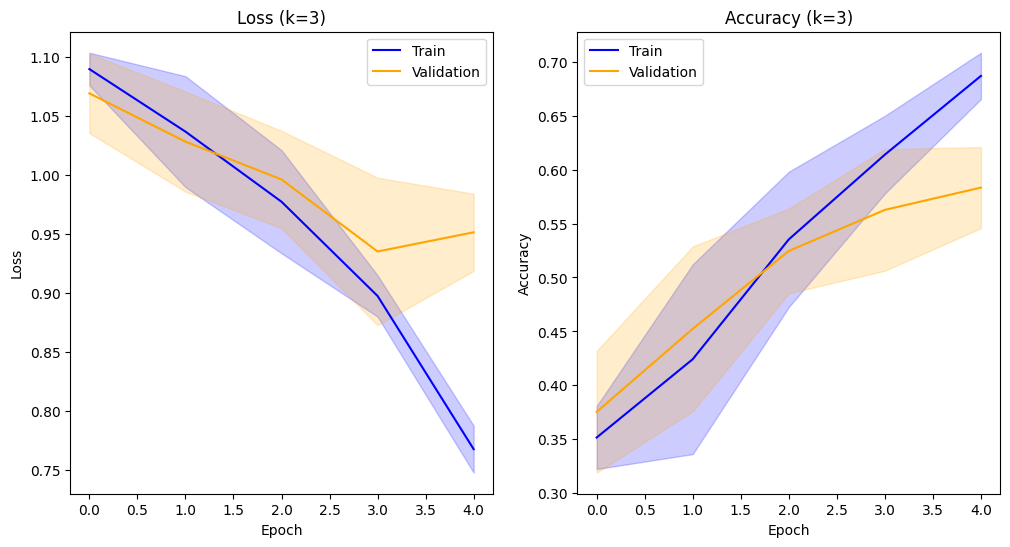

Précision : moyenne=53.016% écart-type=14.590%, k=3


Model: "0_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 32)   │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 89888)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     8,988,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,994,203 (34.31 MB)

 Trainable params: 8,994,203 (34.31 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.3571 - loss: 1.6929 - val_accuracy: 0.3119 - val_loss: 1.0942
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4476 - loss: 1.0455 - val_accuracy: 0.4143 - val_loss: 1.0937
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6167 - loss: 0.8937 - val_accuracy: 0.5405 - val_loss: 0.9904
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7369 - loss: 0.6777 - val_accuracy: 0.5619 - val_loss: 1.0491
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8690 - loss: 0.4345 - val_accuracy: 0.6095 - val_loss: 1.0940
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9155 - loss: 0.2542 - val_accuracy: 0.6214 - val_loss: 1.3292
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9524 - loss: 0.1643 - val_accuracy: 0.6048 - val_loss: 1.4288
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9750 - loss: 0.1144 - val_accuracy: 0.626

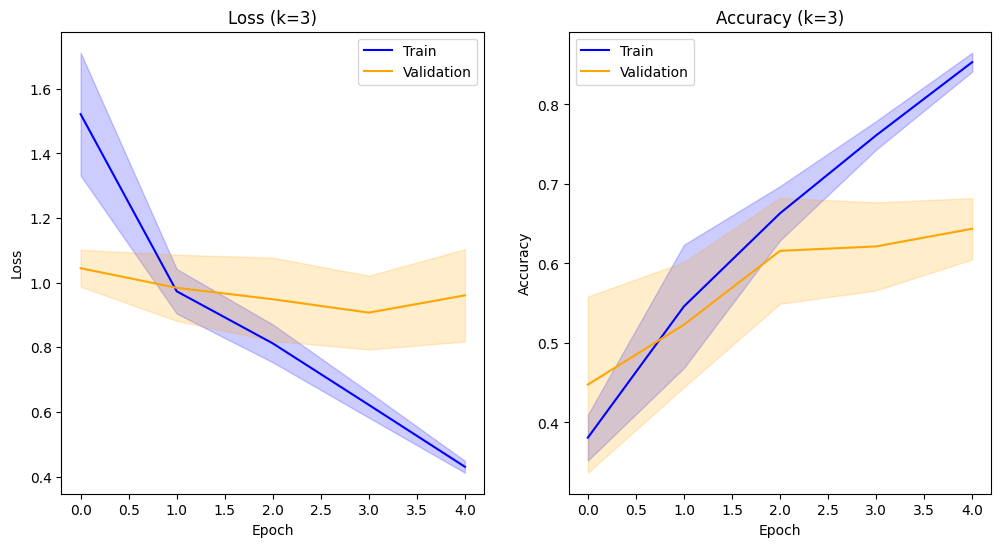

Précision : moyenne=56.190% écart-type=10.318%, k=3


Model: "0_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 105, 105, 32)   │         9,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 50, 50, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 25, 25, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 23, 23, 6)      │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_4 (MaxPooling2D)           │ (None, 11, 11, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 726)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        72,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,675 (330.76 KB)

 Trainable params: 84,675 (330.76 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3726 - loss: 1.1037 - val_accuracy: 0.4024 - val_loss: 1.0963
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4107 - loss: 1.0707 - val_accuracy: 0.4762 - val_loss: 1.0332
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5536 - loss: 0.9474 - val_accuracy: 0.6071 - val_loss: 0.9205
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6369 - loss: 0.8371 - val_accuracy: 0.5619 - val_loss: 0.9707
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6607 - loss: 0.7647 - val_accuracy: 0.6071 - val_loss: 0.8787
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7048 - loss: 0.7309 - val_accuracy: 0.6048 - val_loss: 0.9967
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7202 - loss: 0.6534 - val_accuracy: 0.5976 - val_loss: 1.0076
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7476 - loss: 0.5815 - val_accuracy: 0.573

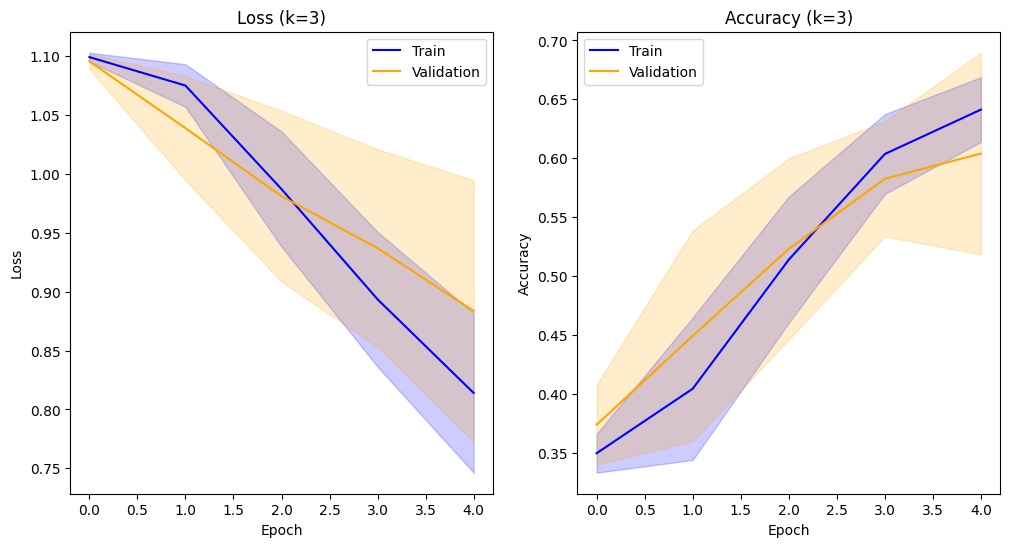

Précision : moyenne=54.683% écart-type=16.127%, k=3


Model: "0_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 32)   │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 89888)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │     1,797,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,803,023 (6.88 MB)

 Trainable params: 1,803,023 (6.88 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3381 - loss: 1.1355 - val_accuracy: 0.3119 - val_loss: 1.0988
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3488 - loss: 1.0985 - val_accuracy: 0.3119 - val_loss: 1.0989
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3476 - loss: 1.0984 - val_accuracy: 0.3119 - val_loss: 1.0992
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3476 - loss: 1.0982 - val_accuracy: 0.3119 - val_loss: 1.0993
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3488 - loss: 1.0994 - val_accuracy: 0.3548 - val_loss: 1.0860
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4179 - loss: 1.0830 - val_accuracy: 0.4548 - val_loss: 1.0873
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3440 - loss: 1.0912 - val_accuracy: 0.4262 - val_loss: 1.0848
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4405 - loss: 1.0692 - val_accuracy: 0.250

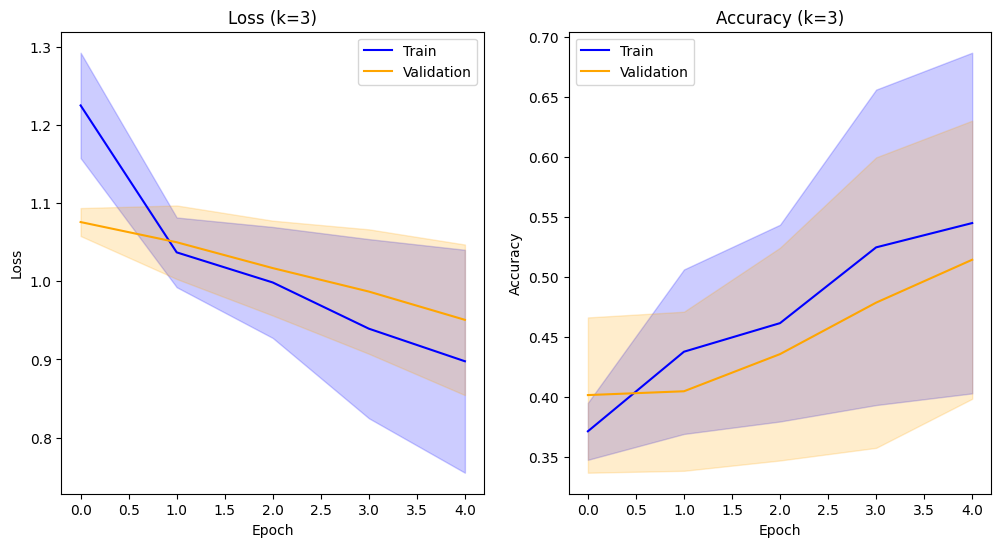

Précision : moyenne=54.444% écart-type=9.978%, k=3


Model: "0_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 107, 107, 32)   │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 51, 51, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 25, 25, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 23, 23, 6)      │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_4 (MaxPooling2D)           │ (None, 11, 11, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 726)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        72,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,807 (315.65 KB)

 Trainable params: 80,807 (315.65 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3286 - loss: 1.0999 - val_accuracy: 0.3214 - val_loss: 1.0964
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4143 - loss: 1.0762 - val_accuracy: 0.4571 - val_loss: 1.1264
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4893 - loss: 1.0259 - val_accuracy: 0.5595 - val_loss: 0.9988
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5774 - loss: 0.9393 - val_accuracy: 0.5333 - val_loss: 0.9689
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6060 - loss: 0.8776 - val_accuracy: 0.5429 - val_loss: 0.9527
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6202 - loss: 0.8102 - val_accuracy: 0.6048 - val_loss: 0.9736
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6738 - loss: 0.7603 - val_accuracy: 0.5548 - val_loss: 1.0746
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7000 - loss: 0.6905 - val_accuracy: 0.571

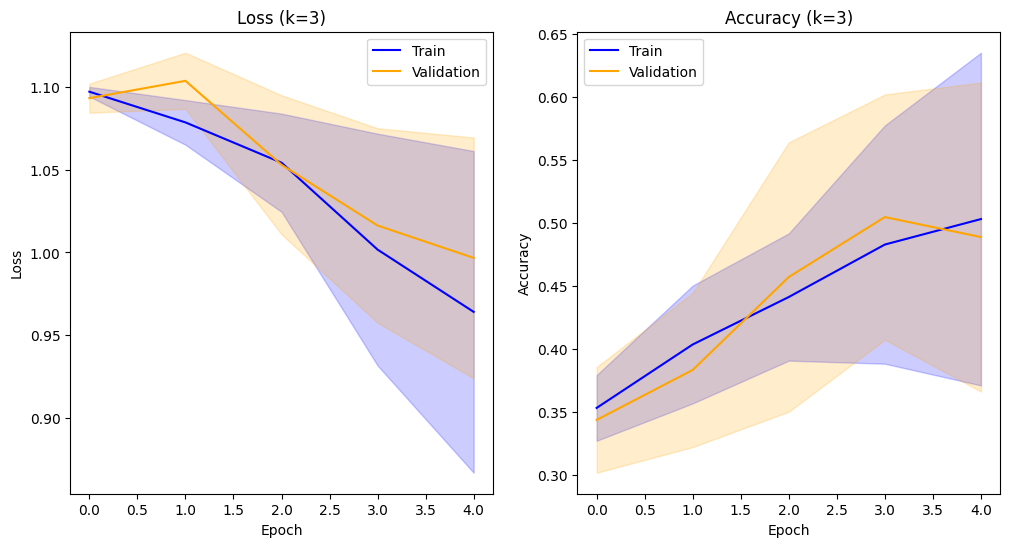

Précision : moyenne=49.365% écart-type=13.670%, k=3
Best entity :
Accuracy : 0.631, Complexity : 9333531.000


Model: "0_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     9,331,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,000,595 (106.81 MB)

 Trainable params: 9,333,531 (35.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,667,064 (71.21 MB)

None
Generation 2


Model: "1_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,667,051 (17.80 MB)

 Trainable params: 4,667,051 (17.80 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4095 - loss: 1.1210 - val_accuracy: 0.5476 - val_loss: 0.9939
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6369 - loss: 0.8633 - val_accuracy: 0.5595 - val_loss: 0.9167
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7167 - loss: 0.6636 - val_accuracy: 0.6357 - val_loss: 0.8503
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8286 - loss: 0.4850 - val_accuracy: 0.6762 - val_loss: 0.7732
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9060 - loss: 0.2985 - val_accuracy: 0.6429 - val_loss: 0.8393
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9619 - loss: 0.1764 - val_accuracy: 0.6810 - val_loss: 0.8144
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9881 - loss: 0.0917 - val_accuracy: 0.6929 - val_loss: 0.8906
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9964 - loss: 0.0581 - val_accuracy: 0.664

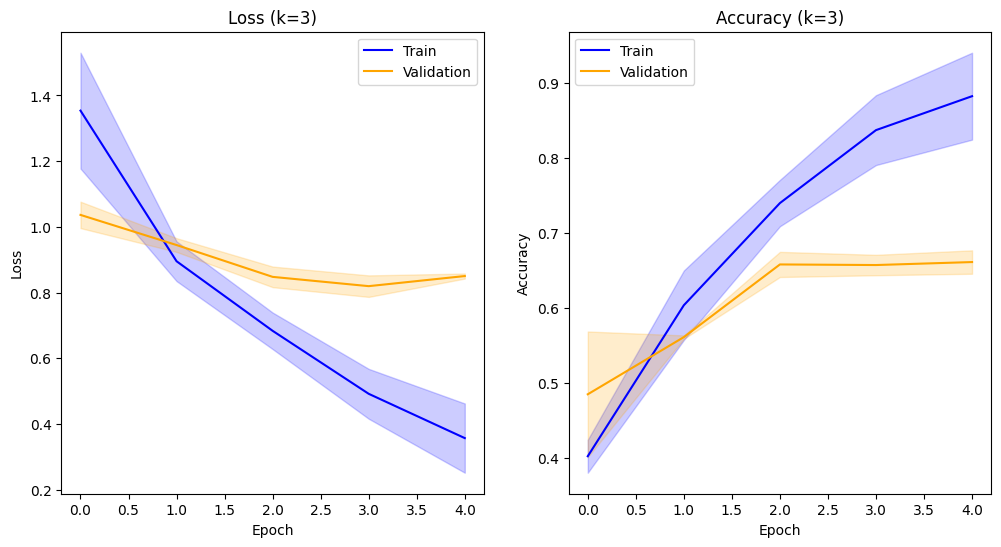

Précision : moyenne=52.778% écart-type=12.668%, k=3


Model: "1_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │     4,665,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,667,731 (17.81 MB)

 Trainable params: 4,667,731 (17.81 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3298 - loss: 4.8762 - val_accuracy: 0.3190 - val_loss: 1.1100
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5488 - loss: 0.9983 - val_accuracy: 0.5905 - val_loss: 0.9993
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6750 - loss: 0.8464 - val_accuracy: 0.5976 - val_loss: 0.9081
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7702 - loss: 0.6293 - val_accuracy: 0.5881 - val_loss: 0.9770
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8655 - loss: 0.4350 - val_accuracy: 0.6619 - val_loss: 0.9205
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9024 - loss: 0.3299 - val_accuracy: 0.6619 - val_loss: 0.8026
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9548 - loss: 0.1752 - val_accuracy: 0.6905 - val_loss: 0.8464
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9869 - loss: 0.1104 - val_accuracy: 0.685

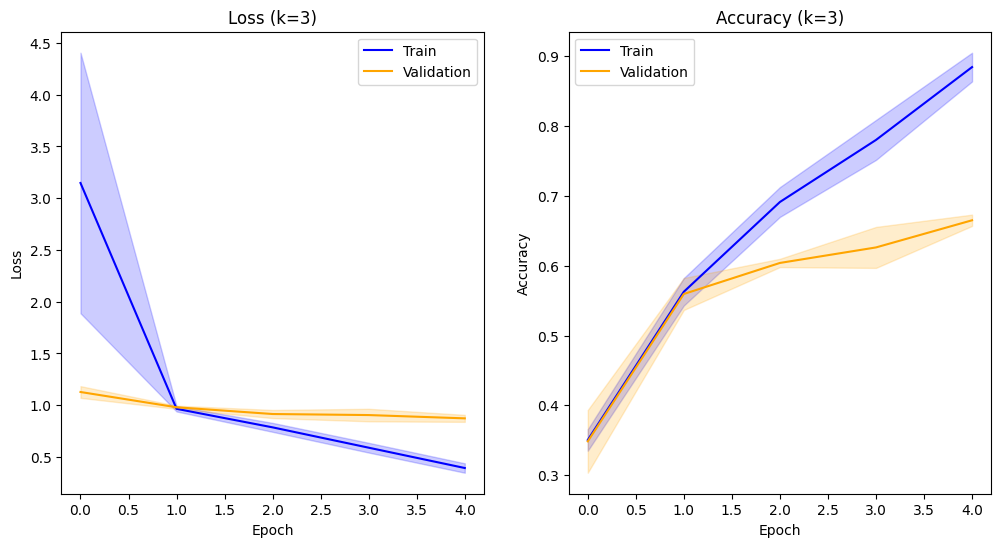

Précision : moyenne=46.270% écart-type=14.639%, k=3


Model: "1_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │       933,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 935,091 (3.57 MB)

 Trainable params: 935,091 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3464 - loss: 1.3339 - val_accuracy: 0.3095 - val_loss: 1.0988
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3500 - loss: 1.0985 - val_accuracy: 0.3119 - val_loss: 1.0989
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3500 - loss: 1.0984 - val_accuracy: 0.3119 - val_loss: 1.0991
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3500 - loss: 1.0984 - val_accuracy: 0.3119 - val_loss: 1.0992
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3500 - loss: 1.0983 - val_accuracy: 0.3119 - val_loss: 1.0994
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3500 - loss: 1.0982 - val_accuracy: 0.3119 - val_loss: 1.0994
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3095 - loss: 1.0988
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3250 - loss:

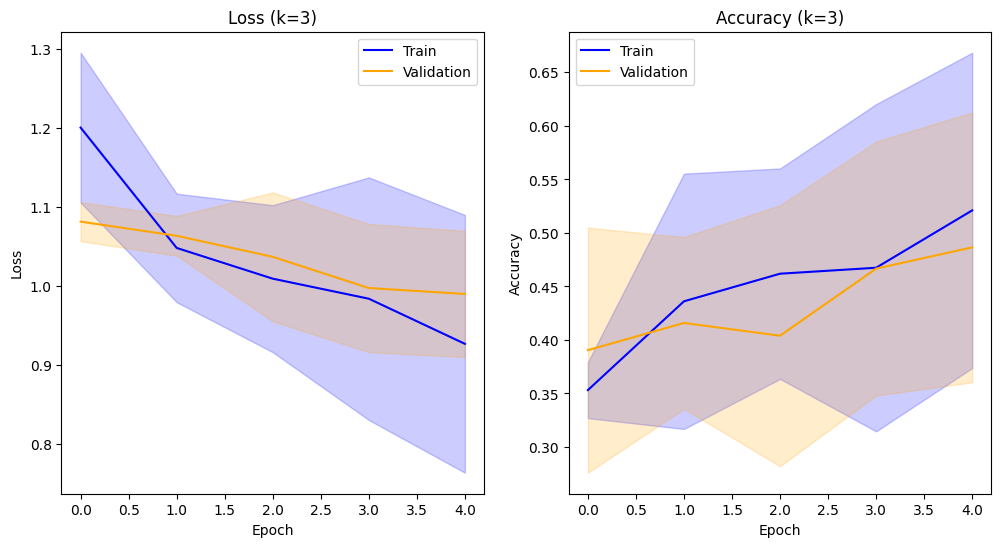

Précision : moyenne=48.651% écart-type=12.650%, k=3


Model: "1_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │     1,866,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,868,251 (7.13 MB)

 Trainable params: 1,868,251 (7.13 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3655 - loss: 1.7177 - val_accuracy: 0.5452 - val_loss: 0.9831
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5940 - loss: 0.8756 - val_accuracy: 0.6095 - val_loss: 0.8721
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7310 - loss: 0.7061 - val_accuracy: 0.6714 - val_loss: 0.7563
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7893 - loss: 0.5529 - val_accuracy: 0.6714 - val_loss: 0.7627
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8690 - loss: 0.4077 - val_accuracy: 0.6833 - val_loss: 0.8061
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9345 - loss: 0.2843 - val_accuracy: 0.6405 - val_loss: 0.9205
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9488 - loss: 0.2088 - val_accuracy: 0.6690 - val_loss: 0.8459
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9726 - loss: 0.1356 - val_accuracy: 0.659

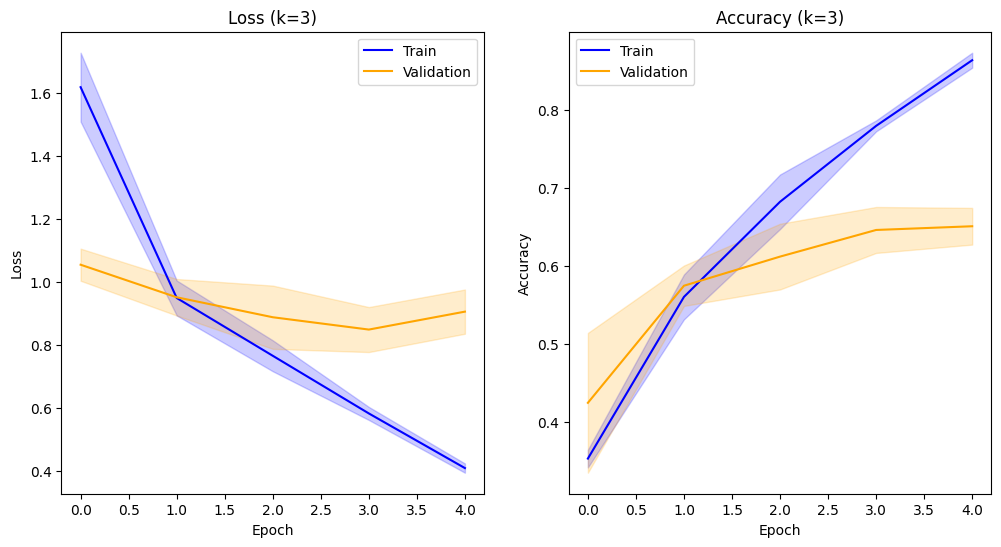

Précision : moyenne=46.667% écart-type=14.732%, k=3


Model: "1_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │     4,665,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,121 (17.81 MB)

 Trainable params: 4,668,121 (17.81 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3702 - loss: 1.2047 - val_accuracy: 0.6143 - val_loss: 0.9779
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6357 - loss: 0.8853 - val_accuracy: 0.6929 - val_loss: 0.8092
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6869 - loss: 0.7577 - val_accuracy: 0.6143 - val_loss: 0.8151
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8000 - loss: 0.5806 - val_accuracy: 0.6476 - val_loss: 0.7976
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8488 - loss: 0.4673 - val_accuracy: 0.6690 - val_loss: 0.8146
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9179 - loss: 0.3060 - val_accuracy: 0.6524 - val_loss: 0.8263
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9393 - loss: 0.2141 - val_accuracy: 0.6500 - val_loss: 0.9759
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9714 - loss: 0.1396 - val_accuracy: 0.671

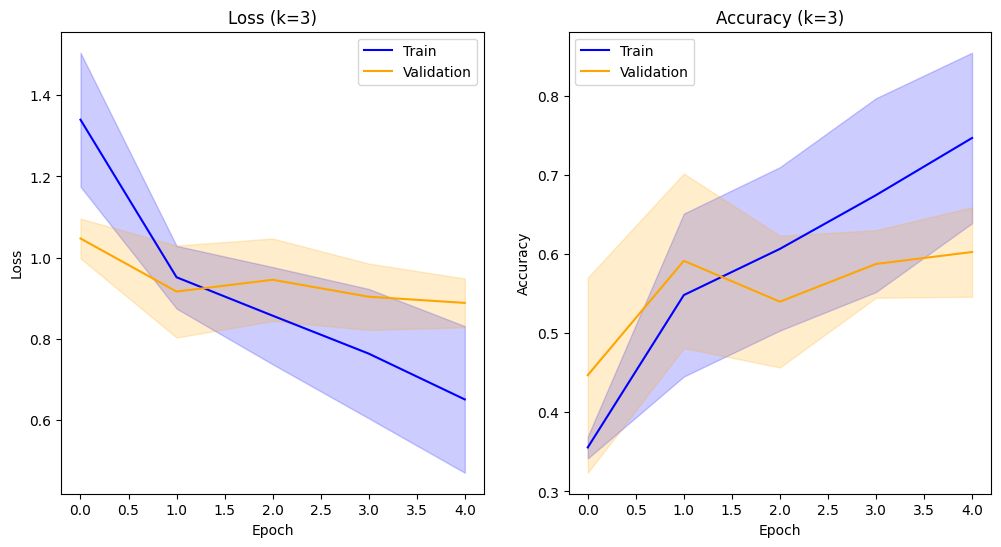

Précision : moyenne=45.794% écart-type=13.837%, k=3


Model: "1_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     9,331,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,334,271 (35.61 MB)

 Trainable params: 9,334,271 (35.61 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3310 - loss: 1.8577 - val_accuracy: 0.3429 - val_loss: 1.0777
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5036 - loss: 1.0282 - val_accuracy: 0.5857 - val_loss: 0.9931
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6179 - loss: 0.8672 - val_accuracy: 0.6286 - val_loss: 0.9234
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7643 - loss: 0.6334 - val_accuracy: 0.6286 - val_loss: 0.9007
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8940 - loss: 0.3720 - val_accuracy: 0.5786 - val_loss: 1.0763
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9369 - loss: 0.2245 - val_accuracy: 0.6238 - val_loss: 0.8992
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9798 - loss: 0.1162 - val_accuracy: 0.6286 - val_loss: 1.0500
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9952 - loss: 0.0608 - val_accuracy: 0.621

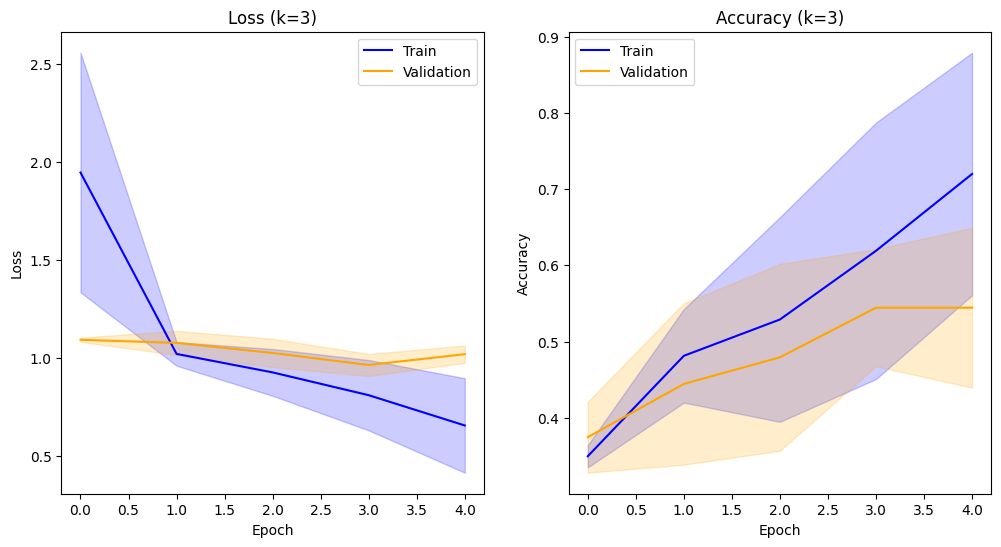

Précision : moyenne=46.825% écart-type=11.733%, k=3


Model: "1_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     4,147,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,149,531 (15.83 MB)

 Trainable params: 4,149,531 (15.83 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3524 - loss: 1.7991 - val_accuracy: 0.3524 - val_loss: 1.0889
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5881 - loss: 0.9450 - val_accuracy: 0.5548 - val_loss: 0.9659
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6940 - loss: 0.7833 - val_accuracy: 0.5810 - val_loss: 0.9148
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7119 - loss: 0.6550 - val_accuracy: 0.6738 - val_loss: 0.8105
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8250 - loss: 0.5088 - val_accuracy: 0.6405 - val_loss: 0.8847
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8738 - loss: 0.4123 - val_accuracy: 0.6714 - val_loss: 0.8129
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9119 - loss: 0.3104 - val_accuracy: 0.6452 - val_loss: 0.8832
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9476 - loss: 0.2293 - val_accuracy: 0.631

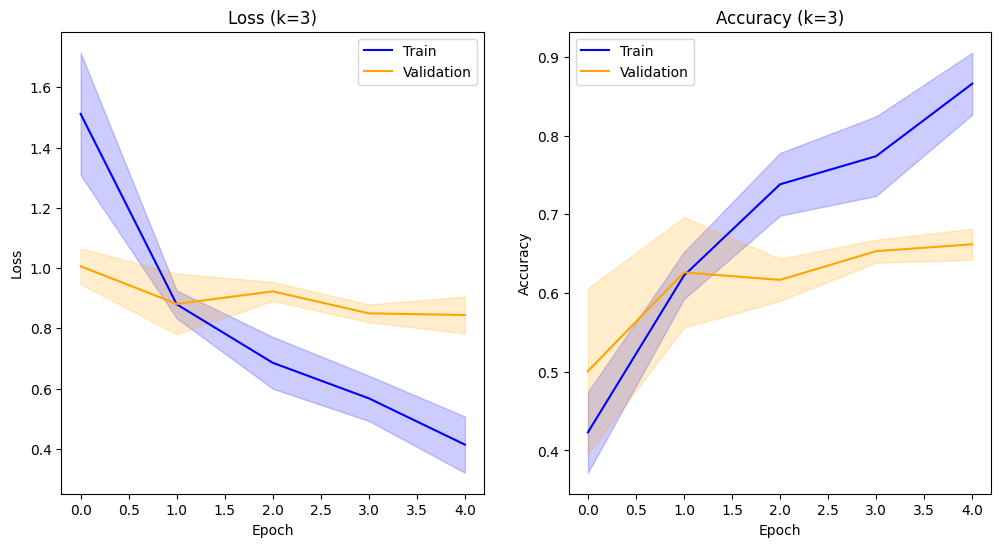

Précision : moyenne=65.397% écart-type=6.472%, k=3


Model: "1_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     9,331,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,333,531 (35.60 MB)

 Trainable params: 9,333,531 (35.60 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3690 - loss: 2.1614 - val_accuracy: 0.4310 - val_loss: 1.0688
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4357 - loss: 1.0471 - val_accuracy: 0.5929 - val_loss: 0.9404
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4762 - loss: 0.9950 - val_accuracy: 0.5667 - val_loss: 0.9311
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4905 - loss: 0.9695 - val_accuracy: 0.6024 - val_loss: 0.8789
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4929 - loss: 0.9368 - val_accuracy: 0.6119 - val_loss: 0.8886
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5393 - loss: 0.9290 - val_accuracy: 0.6452 - val_loss: 0.8632
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5488 - loss: 0.9065 - val_accuracy: 0.6810 - val_loss: 0.8379
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5655 - loss: 0.8557 - val_accuracy: 0.681

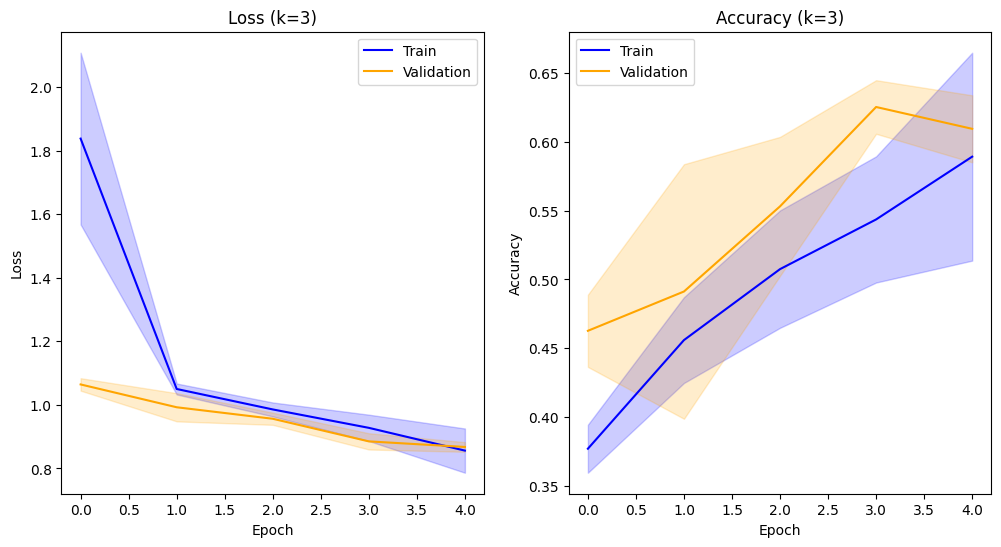

Précision : moyenne=55.635% écart-type=11.083%, k=3


Model: "1_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 52, 52, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 26, 26, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4056)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        40,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,265 (172.91 KB)

 Trainable params: 44,265 (172.91 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3405 - loss: 1.0912 - val_accuracy: 0.3119 - val_loss: 1.0566
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3905 - loss: 1.0310 - val_accuracy: 0.4310 - val_loss: 0.9926
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5226 - loss: 0.9836 - val_accuracy: 0.5429 - val_loss: 0.9648
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5702 - loss: 0.9477 - val_accuracy: 0.6214 - val_loss: 0.9642
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6214 - loss: 0.9113 - val_accuracy: 0.5929 - val_loss: 0.9856
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6643 - loss: 0.8863 - val_accuracy: 0.6286 - val_loss: 0.9195
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6881 - loss: 0.7791 - val_accuracy: 0.6595 - val_loss: 0.7954
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7512 - loss: 0.6422 - val_accuracy: 0.659

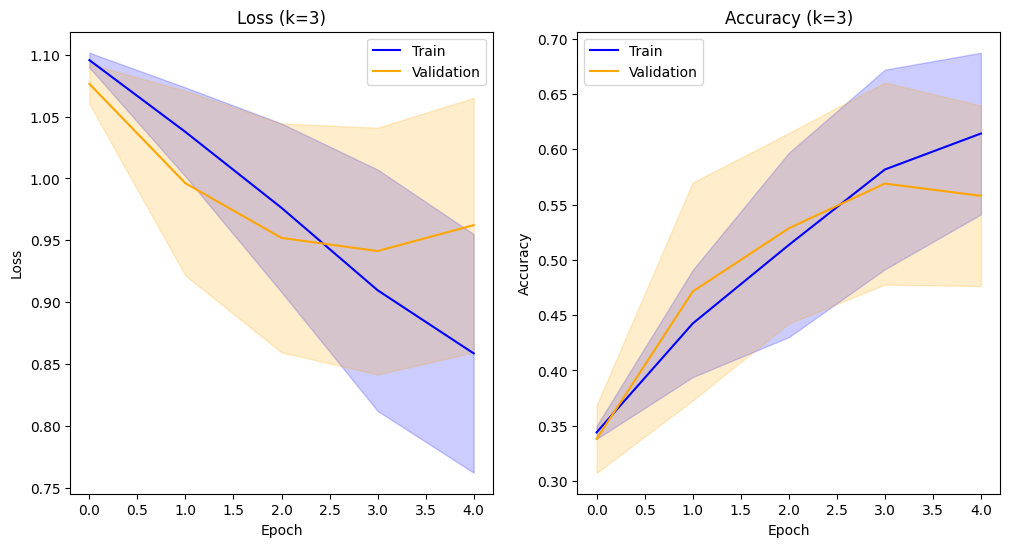

Précision : moyenne=46.508% écart-type=16.289%, k=3


Model: "1_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 52, 52, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 26, 26, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4056)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │       202,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,665 (807.29 KB)

 Trainable params: 206,665 (807.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3607 - loss: 1.1114 - val_accuracy: 0.4190 - val_loss: 1.0946
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4643 - loss: 1.0693 - val_accuracy: 0.4881 - val_loss: 1.0375
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5798 - loss: 0.9686 - val_accuracy: 0.5881 - val_loss: 0.9455
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6333 - loss: 0.8563 - val_accuracy: 0.6214 - val_loss: 0.9072
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7214 - loss: 0.7092 - val_accuracy: 0.6190 - val_loss: 0.8783
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7952 - loss: 0.5739 - val_accuracy: 0.5905 - val_loss: 1.0525
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8560 - loss: 0.4253 - val_accuracy: 0.5952 - val_loss: 1.0493
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9119 - loss: 0.2824 - val_accuracy: 0.588

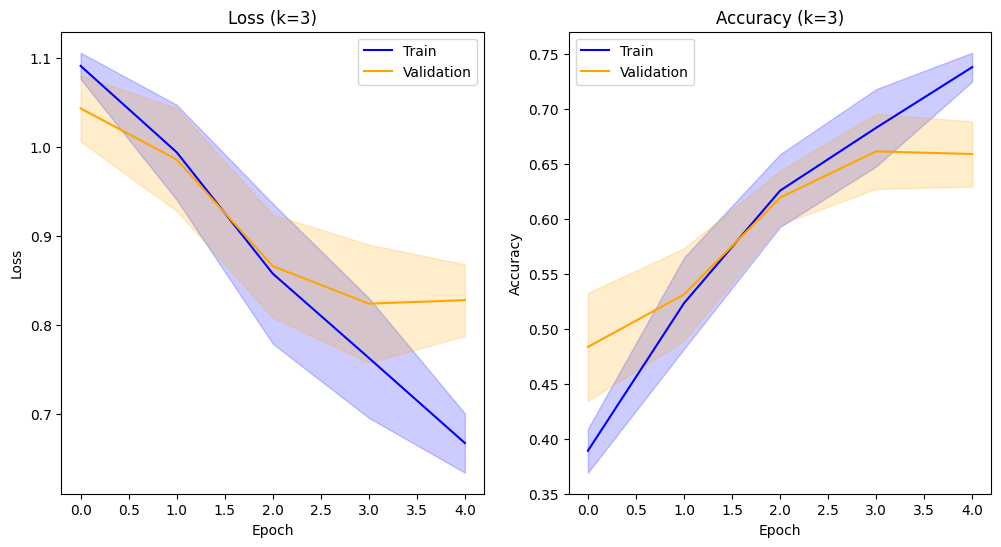

Précision : moyenne=60.556% écart-type=8.703%, k=3


Model: "1_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 52, 52, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 26, 26, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4056)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │       405,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,665 (1.56 MB)

 Trainable params: 409,665 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4000 - loss: 1.0789 - val_accuracy: 0.5214 - val_loss: 1.0034
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5774 - loss: 0.9400 - val_accuracy: 0.3905 - val_loss: 1.1202
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6024 - loss: 0.8639 - val_accuracy: 0.4952 - val_loss: 1.0445
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7143 - loss: 0.7188 - val_accuracy: 0.6357 - val_loss: 0.8984
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7952 - loss: 0.5448 - val_accuracy: 0.6238 - val_loss: 0.9265
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8440 - loss: 0.4052 - val_accuracy: 0.6500 - val_loss: 0.9093
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8976 - loss: 0.3157 - val_accuracy: 0.6190 - val_loss: 1.0855
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9095 - loss: 0.2453 - val_accuracy: 0.595

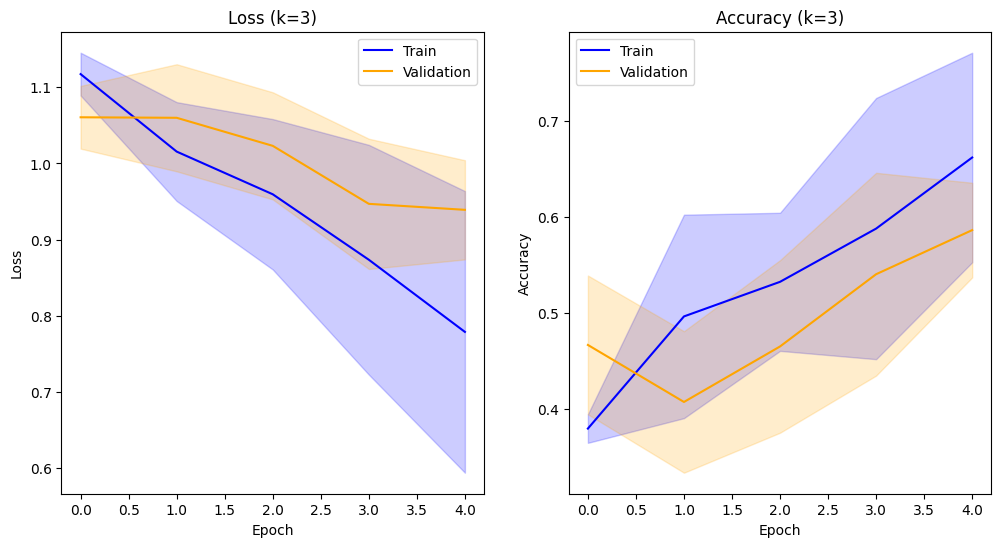

Précision : moyenne=54.365% écart-type=12.685%, k=3


Model: "1_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 52, 52, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 26, 26, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4056)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │       405,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 410,405 (1.57 MB)

 Trainable params: 410,405 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3488 - loss: 1.0968 - val_accuracy: 0.3167 - val_loss: 1.0835
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4131 - loss: 1.0408 - val_accuracy: 0.4000 - val_loss: 1.0494
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5631 - loss: 0.9493 - val_accuracy: 0.5524 - val_loss: 0.9994
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6940 - loss: 0.8109 - val_accuracy: 0.6024 - val_loss: 0.9683
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7595 - loss: 0.6466 - val_accuracy: 0.5762 - val_loss: 0.9851
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8226 - loss: 0.4689 - val_accuracy: 0.5857 - val_loss: 1.1142
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8560 - loss: 0.4242 - val_accuracy: 0.5119 - val_loss: 1.2819
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9107 - loss: 0.2500 - val_accuracy: 0.578

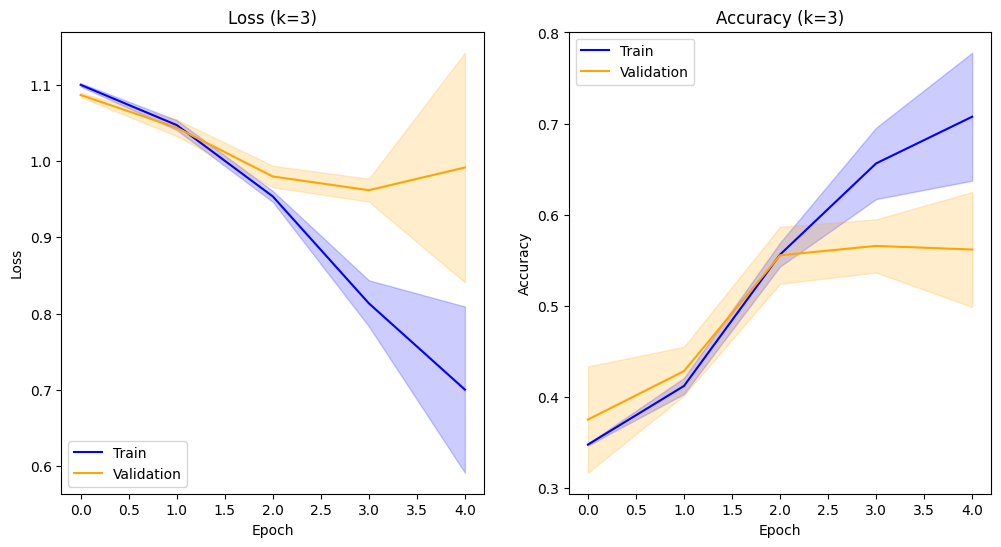

Précision : moyenne=52.937% écart-type=12.401%, k=3


Model: "1_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 52, 52, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 26, 26, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 24, 24, 6)      │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_4 (MaxPooling2D)           │ (None, 12, 12, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        43,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,395 (185.14 KB)

 Trainable params: 47,395 (185.14 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3488 - loss: 1.1018 - val_accuracy: 0.3548 - val_loss: 1.0881
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4298 - loss: 1.0491 - val_accuracy: 0.3619 - val_loss: 1.0959
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5869 - loss: 0.9276 - val_accuracy: 0.6286 - val_loss: 0.8703
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5940 - loss: 0.8931 - val_accuracy: 0.6095 - val_loss: 0.8757
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6524 - loss: 0.8047 - val_accuracy: 0.6595 - val_loss: 0.7842
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6714 - loss: 0.7645 - val_accuracy: 0.6310 - val_loss: 0.9094
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6214 - loss: 0.8336 - val_accuracy: 0.6143 - val_loss: 0.8285
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7095 - loss: 0.7327 - val_accuracy: 0.652

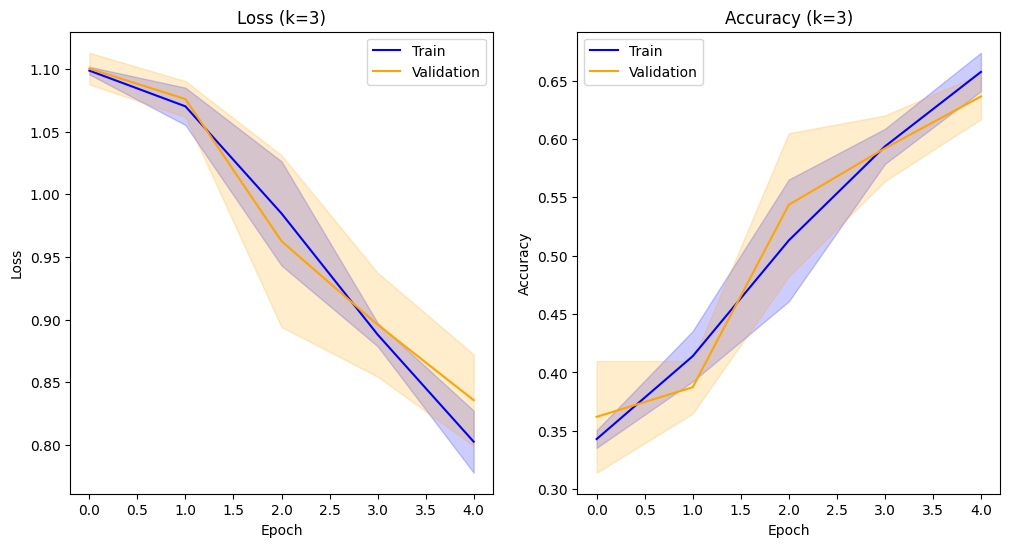

Précision : moyenne=46.587% écart-type=14.976%, k=3


Model: "1_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │     4,665,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,671,281 (17.82 MB)

 Trainable params: 4,671,281 (17.82 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3452 - loss: 1.1648 - val_accuracy: 0.3119 - val_loss: 1.0988
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3500 - loss: 1.0985 - val_accuracy: 0.3119 - val_loss: 1.0990
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3500 - loss: 1.0984 - val_accuracy: 0.3119 - val_loss: 1.0991
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3500 - loss: 1.0984 - val_accuracy: 0.3119 - val_loss: 1.0991
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3500 - loss: 1.0984 - val_accuracy: 0.3119 - val_loss: 1.0992
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3500 - loss: 1.0983 - val_accuracy: 0.3119 - val_loss: 1.0993
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3119 - loss: 1.0988
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.3905 - loss

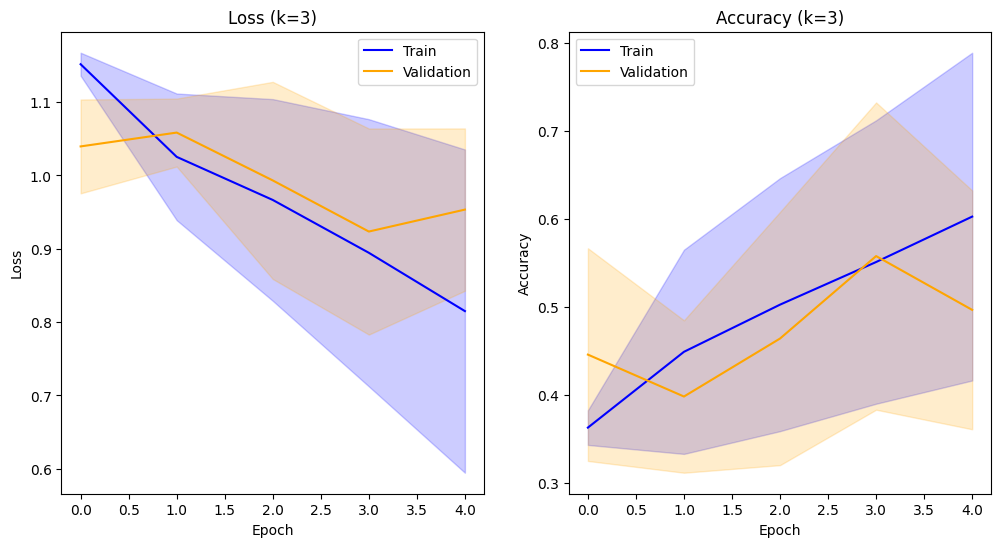

Précision : moyenne=47.698% écart-type=16.229%, k=3


Model: "1_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 74, 74, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 72, 72, 32)     │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 34, 34, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 17, 17, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1734)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        86,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,565 (353.77 KB)

 Trainable params: 90,565 (353.77 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3143 - loss: 1.1126 - val_accuracy: 0.3119 - val_loss: 1.0982
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3488 - loss: 1.0921 - val_accuracy: 0.3214 - val_loss: 1.0790
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4000 - loss: 1.0552 - val_accuracy: 0.4571 - val_loss: 1.0430
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5202 - loss: 1.0072 - val_accuracy: 0.5381 - val_loss: 1.0102
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5738 - loss: 0.9575 - val_accuracy: 0.5833 - val_loss: 0.9659
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6226 - loss: 0.8778 - val_accuracy: 0.5857 - val_loss: 0.9766
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6679 - loss: 0.8197 - val_accuracy: 0.6190 - val_loss: 0.9075
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7000 - loss: 0.7230 - val_accuracy: 0.614

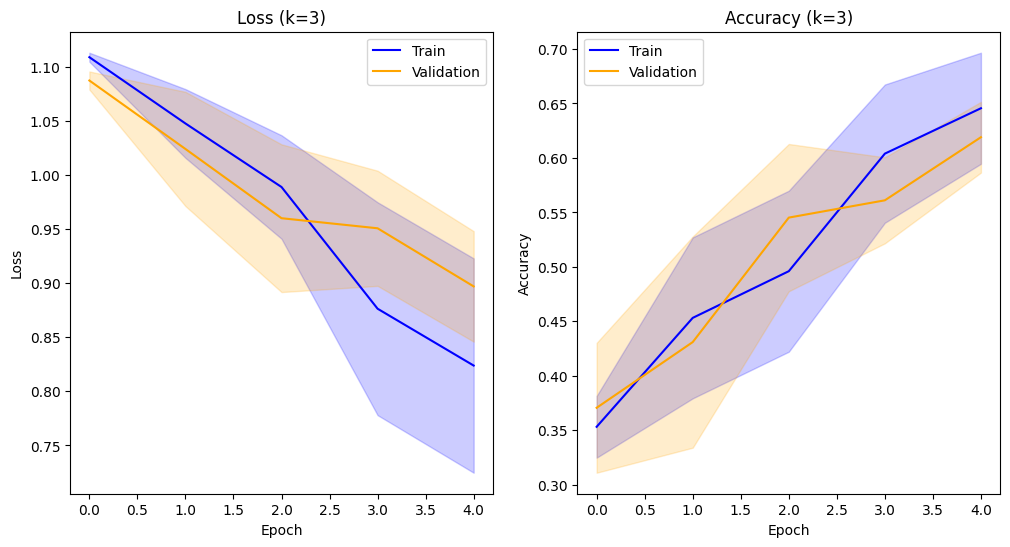

Précision : moyenne=55.079% écart-type=14.699%, k=3


Model: "1_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 52, 52, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 26, 26, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 24, 24, 6)      │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_4 (MaxPooling2D)           │ (None, 12, 12, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        86,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,795 (354.67 KB)

 Trainable params: 90,795 (354.67 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3488 - loss: 1.0981 - val_accuracy: 0.3143 - val_loss: 1.0970
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3869 - loss: 1.0850 - val_accuracy: 0.3905 - val_loss: 1.0657
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5095 - loss: 1.0064 - val_accuracy: 0.5357 - val_loss: 0.9874
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5952 - loss: 0.9213 - val_accuracy: 0.5357 - val_loss: 0.9609
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6262 - loss: 0.8567 - val_accuracy: 0.5667 - val_loss: 0.9550
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6821 - loss: 0.7792 - val_accuracy: 0.5190 - val_loss: 1.0085
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6976 - loss: 0.7242 - val_accuracy: 0.5762 - val_loss: 0.9765
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7298 - loss: 0.6630 - val_accuracy: 0.554

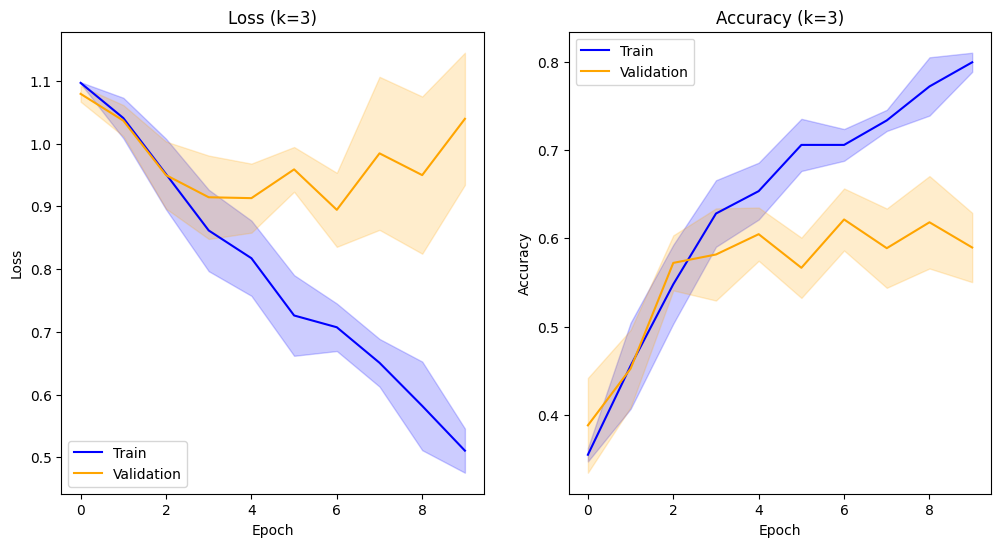

Précision : moyenne=62.698% écart-type=4.958%, k=3


Model: "1_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 52, 52, 6)      │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 26, 26, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 24, 24, 6)      │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_4 (MaxPooling2D)           │ (None, 12, 12, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        86,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,535 (357.56 KB)

 Trainable params: 91,535 (357.56 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3167 - loss: 1.0994 - val_accuracy: 0.3405 - val_loss: 1.0924
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3333 - loss: 1.0861 - val_accuracy: 0.3905 - val_loss: 1.0598
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4381 - loss: 1.0317 - val_accuracy: 0.5048 - val_loss: 0.9955
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5536 - loss: 0.9140 - val_accuracy: 0.6524 - val_loss: 0.8427
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6048 - loss: 0.8443 - val_accuracy: 0.6905 - val_loss: 0.7547
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7036 - loss: 0.7550 - val_accuracy: 0.6738 - val_loss: 0.7516
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6929 - loss: 0.7529 - val_accuracy: 0.6881 - val_loss: 0.7235
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7583 - loss: 0.6181 - val_accuracy: 0.652

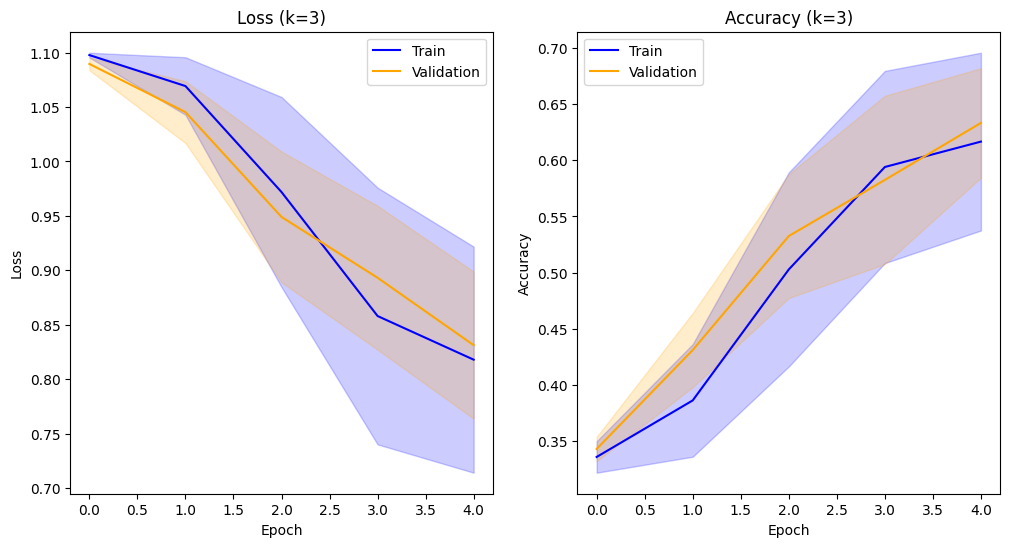

Précision : moyenne=45.952% écart-type=16.366%, k=3


Model: "1_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     4,147,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,149,531 (15.83 MB)

 Trainable params: 4,149,531 (15.83 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3286 - loss: 1.6027 - val_accuracy: 0.3310 - val_loss: 1.0906
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4012 - loss: 1.0743 - val_accuracy: 0.5214 - val_loss: 1.0300
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4726 - loss: 1.0256 - val_accuracy: 0.6024 - val_loss: 0.9677
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5274 - loss: 0.9889 - val_accuracy: 0.5357 - val_loss: 0.9399
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5762 - loss: 0.9411 - val_accuracy: 0.6905 - val_loss: 0.8658
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6321 - loss: 0.8544 - val_accuracy: 0.7095 - val_loss: 0.8338
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6536 - loss: 0.8160 - val_accuracy: 0.6786 - val_loss: 0.8221
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6607 - loss: 0.7568 - val_accuracy: 0.714

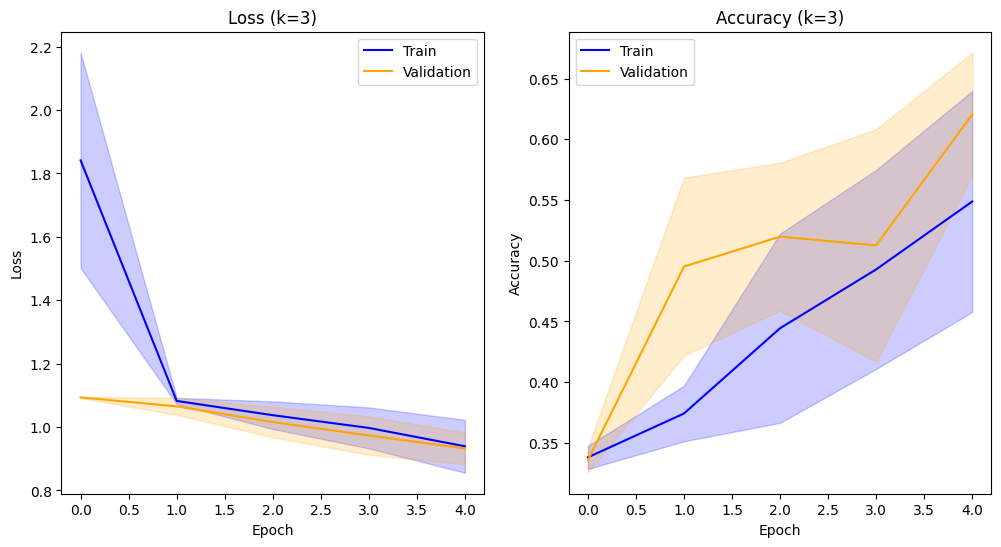

Précision : moyenne=47.063% écart-type=18.769%, k=3


Model: "1_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 32)   │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │     9,331,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,372,083 (35.75 MB)

 Trainable params: 9,372,083 (35.75 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20


: 

In [17]:
# Chargement du jeu de données d'entraînement et de test
X_train, y_train, X_test, y_test = load_dataset()

# Prétraitement des données : nettoyage et normalisation
X_train, X_test = clean_data(X_train, X_test)


pop = [Entity(cDims, dDims, dropout, input_shape, output_shape, "0_0")] # garder la base pour le controle
conf = [[len(cDims), cDims.copy(), len(dDims), dDims.copy(), dropout.copy()]]
for i in range(num_pop - 1):
    pop.append(Entity(*mutate_unique(cDims.copy(), dDims.copy(), conf, dropout), input_shape, output_shape, "0_"+str(i+1)))
for i in range(num_gen):
    # ENTRAINEMENT + EVAL

    print(f"Generation {i+1}")
    prev_best = pop[0]
    baseline_accuracy = prev_best.accuracy
    for entity in pop:
        # Un seul entrainement pour le meilleur precedent
        if entity is prev_best and baseline_accuracy is not None:
            continue
        run_evaluation(folds=folds, epochs=epochs, model=entity, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    
    # Clean RAM
    gc.collect()
    tf.keras.backend.clear_session()


    # SELECTION (A AMELIORER)
    
    # on vire ceux qui sont moins precis que le meilleur precedent
    if baseline_accuracy is None:
        baseline_accuracy = pop[0].accuracy
    pop = [entity for entity in pop if entity.accuracy >= baseline_accuracy]
    # on trie par simplicite
    pop.sort(key=lambda x: -x.complexity)
    # on choisi le plus simple
    best_entities = [pop[0]]

    print("Best entity :")
    print(f"Accuracy : {best_entities[0].accuracy:.3f}, Complexity : {best_entities[0].complexity:.3f}")
    print(best_entities[0].summary())

    # MUTATRON !!!!

    # generer new pop en mutant la best
    pop = [best_entities[0]]
    conf = [[best_entities[0].cLayers, best_entities[0].cDims.copy(), best_entities[0].dLayers, best_entities[0].dDims.copy(), best_entities[0].dropout.copy()]]
    for j in range(num_pop - 1):
        pop.append(Entity(
            *mutate_unique(
                best_entities[0].cDims.copy(),
                best_entities[0].dDims.copy(),
                conf,
                best_entities[0].dropout.copy()
            ),
            input_shape,
            output_shape,
            str(i+1)+"_"+str(j+1)
        ))
print("Final best entity :")
print(f"Accuracy : {best_entities[0].accuracy:.3f}, Complexity : {best_entities[0].complexity:.3f}")
print(best_entities[0].summary())
print(f"param best: conv={best_entities[0].cLayers}, cDims={best_entities[0].cDims}, dense={best_entities[0].dLayers}, dDims={best_entities[0].dDims}, dropout={best_entities[0].dropout}")

